# ***Seattle Energy Benchmarking***

## *Online version*

An online version of this notebook is available on *Google Colab* at the following address: 

https://colab.research.google.com/drive/1xS0aslIHaJHpGaC1XozQCkEKbhc6uCAC?usp=sharing

# ***- 1 -*** About this project

## *A -* Introduction

In this project, we are working for the city of Seattle and with its open data. The goal is to facilitate the building energy statement generation for the non-residential buildings.

Complex and complete energy statements have been made by the city, but they represent a big effort and our task is to simplify the process using our Data Science skills.

In this project, we have multiple objectives:
* Predict the energy consumption and green house gas emissions of the buildings,
* Investigate the EnergyStar score and determinate if it is relevant for the greenhouse gas emissions predictions.

In order to fullfill these objectives:
* We are going to implement custom Sklearn transformers to create a pipeline for our data.
* Then, we train and evaluate multiple machine learning models to select the best estimator for our problematic.

The original dataset can be found at the following address:

https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking/code

## *B -* How to read this project

This project is divided into 2 notebooks.
Each notebook is organized in chapters:


**Common chapters**
* ***-1 -*** **About this project** is *what you are reading now*. This is the *README*.
* ***0 -*** **Environment**: sets up the necessary environment to run this notebook. In this part, we will also develop the toolbox to automate the exploration of the dataset. *Disclaimer: This part is not really about Data Science, but more about code and automatized processing. It is not necessary to read this part unless you have a good knowledge of python and are interested on how I delevelopped these functions. Fee free to skip it.*
* ***+1 -*** **Conclusion**: The notebooks conclusion.

***P3.1 -*** **Exploration** (*first notebook*)
* ***1 -*** **Cleaning and Exploration**: main dataset characteristics and basic data cleaning.
* ***2 -*** **Going Deeper**: characteristics of the main features of the dataset.

***P3.2 -*** **Feature Enginering** (*second notebook*)
* ***3 -*** **Feature Engineering**: creation of the preprocessing pipeline.
* ***4 -*** **Energy Use Prediction**: prediction of the energy use per building.
* ***5 -*** **Greenhouse Gas Emissions Prediction**: prediction of the greenhouse gas emissions and evaluation of the impact of the *EnergyStarScore* feature.

# ***0 -*** **Environment**

## *A -* Importing Libraries

Let's import the libraries that will be used in this project.

In [1]:
!pip install shap
import random
import shap
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, FunctionTransformer, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler,FunctionTransformer, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor, plot_tree
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import joblib
import re
import geopy.distance

     |████████████████████████████████| 564 kB 5.1 MB/s 


## *B -* Utilities

In [2]:
template = 'plotly_dark'
plt.rcParams["figure.figsize"] = (14,12)

### *a -* Dataset Versioning

I have developped the **Dataset()** class during this project as a simple dataset versioning tool.

*You can skip this part in you are not interested in code.*

In [3]:
def get_num(dataframe:pd.DataFrame):

  return dataframe.select_dtypes([int,float])


def get_cat(dataframe:pd.DataFrame):

  return dataframe.select_dtypes(object)


def get_feat(dataframe:pd.DataFrame, starts_with:str, inverse=False):

  # or tuple of strings
  if inverse == True:
    return [feature for feature in dataframe.columns if feature.endswith(starts_with)]
  else:
    return [feature for feature in dataframe.columns if feature.startswith(starts_with)]


def gen_feat(dataframe:pd.DataFrame, prefix:str, inverse=False):

    if inverse == True:
      return [f'{prefix}{feature}' for feature in dataframe.columns]
    else:
      return [f'{feature}{prefix}' for feature in dataframe.columns]

  
class Dataset():


  def __init__(self, dataframe:pd.DataFrame):

    init_name = 'original'
    self.versions_index = {init_name:0}
    self.versions = {0:self.dict_constructor(dataframe=dataframe, step=init_name, index=0)}
    self.current_version = 0

    print(f'Version {self.current_version}: "{init_name}" initialized') 


  def last_index(self):

    return list(self.versions_index.values())[-1]


  def add_index(self, step, index):

    if step in list(self.versions_index.keys()) or step=='current':
      print('\nKey already in index, choose another key.\n')
      return False

    else:
      self.versions_index[step] = index
      return True


  def dict_constructor(self, dataframe, step, index):

    if index == 0:
      samples_diff = dataframe.shape[0]
      features_diff = dataframe.shape[1]
      index_diff = dataframe.index
      columns_diff = dataframe.columns

    else:
      last_version = self.versions.get(index-1)
      samples_diff = last_version.get('samples') - dataframe.shape[0]
      features_diff = last_version.get('features') - dataframe.shape[1]
      index_diff = last_version.get('index').difference(dataframe.index)
      columns_diff = last_version.get('columns').difference(dataframe.columns)

    dataframe_dict = {
      'name': step,
      'dataframe': dataframe,
      'samples': dataframe.shape[0],
      'samples_diff': samples_diff,
      'features': dataframe.shape[1],
      'features_diff': features_diff,
      'index': dataframe.index,
      'index_diff': index_diff,
      'columns': dataframe.columns,
      'columns_diff': columns_diff
    }

    return dataframe_dict


  def save_version(self, updated_dataframe:pd.DataFrame, step:str):

    next_version = self.last_index() + 1
    key_pass = self.add_index(step=step, index=next_version)
    if key_pass == True:
      self.versions[next_version] = self.dict_constructor(dataframe=updated_dataframe, step=step, index=next_version)
      self.current_version = next_version
      print(f'\nVersion {next_version}: "{step}" saved\n')    


  def parse_step(self, step):

    if type(step) == str:
      version_index = self.versions_index.get(step)
      version_name = step
    if type(step) == int:
      version_index = step
      version_name = self.versions.get(version_index).get('name')
    return version_index, version_name


  def get_version(self, step):

    version_index, version_name = self.parse_step(step)

    return self.versions.get(version_index)


  def delete_version(self, step):

    version_index, version_name = self.parse_step(step)
    del self.versions_index[version_name]
    del self.versions[version_index]

    print(f'\nVersion {version_index}: "{version_name}" deleted\n')


  def pull_features(self, features, step=0):

    return self.get_version(self.current_version).get('dataframe').join(self.get_version(step).get('dataframe')[features], how='inner')


  def get(self, item='dataframe', step='current'):

    if step == 'current': version = self.versions.get(self.current_version)
    elif step == 'latter': version = self.versions.get(self.current_version-1)
    else: version = self.get_version(step)

    try: 
      item = version.get(item)
      return item
    except KeyError: 
      print('\nKey error, try generating the item first.\n')


  def num_report(self, fig_fill_min=100):

    dataframe = self.get()

    samples = dataframe.shape[0]
    report = dataframe.select_dtypes([int, float, 'datetime']).describe().transpose()
    report['fill_%'] = ((report['count'] / samples) * 100).astype(float).round(2)
    report['nans'] = dataframe.isna().sum()
    report['nans_%'] = ((report['nans'] / samples) * 100).astype(float).round(2)

    for i in report.index:
      zeroes_count = dataframe[i][dataframe[i] == 0].shape[0]
      report.loc[i, 'zeroes'] = zeroes_count
      report.loc[i, 'zeroes_%'] = round(((zeroes_count / samples) * 100), 2)

    report = report[['count', 'fill_%', 'nans', 'nans_%','zeroes', 'zeroes_%','mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    report = report.sort_values(by='count', ascending=False).rename_axis(mapper='feature', axis=0)
    report_df = report[report['fill_%'] >= fig_fill_min][['fill_%', 'nans_%', 'zeroes_%']].transpose()
    report_fig = go.Figure(data=[go.Bar(name=str(report_df.index[index]), x=list(report_df.columns.values), y=list(report_df.iloc[index,:].values)) for index in range(report_df.shape[0])])

    if fig_fill_min == 0: title = 'numerical features characteristics'
    else: title = f'numerical features characteristics (fill >= {fig_fill_min}%: {report_df.shape[1]})'

    report_fig.update_layout(template=template,title=title)
    report_fig.show()

    self.versions[self.current_version]['numericals'] = report


  def cat_report(self, fig_fill_min=100):

    dataframe = self.get()

    samples = dataframe.shape[0]
    report = dataframe.select_dtypes('object').describe().transpose()
    report['fill_%'] = ((report['count'] / samples) * 100).astype(float).round(2)
    report['uniques_%'] = ((report['unique'] / samples) * 100).astype(float).round(2)
    report['nans'] = dataframe.isna().sum()
    report['nans_%'] = ((report['nans'] / samples) * 100).astype(float).round(2)
    report = report[['count', 'fill_%', 'unique', 'uniques_%', 'nans', 'nans_%', 'top', 'freq']]
    report = report.sort_values(by='count', ascending=False).rename_axis(mapper='feature', axis=0)
    report_df = report[report['fill_%'] >= fig_fill_min][['fill_%', 'nans_%', 'uniques_%']].transpose()
    report_fig = go.Figure(data=[go.Bar(name=str(report_df.index[index]), x=list(report_df.columns.values), y=list(report_df.iloc[index,:].values)) for index in range(report_df.shape[0])])

    if fig_fill_min == 0: title = 'categorical features characteristics'
    else: title = f'categorical features characteristics (fill >= {fig_fill_min}%: {report_df.shape[1]})'

    report_fig.update_layout(template=template,title=title)
    report_fig.show()

    self.versions[self.current_version]['categoricals'] = report


  def report(self, fig_fill_min=0):

    dataframe = self.get()

    if self.current_version > 0:

      version_old = self.versions.get(self.current_version-1)
      samples_old, features_old = version_old.get('samples'), version_old.get('features')
      samples_diff = samples_old - dataframe.shape[0]
      samples_percent = round((samples_diff / samples_old) * 100, 2)
      features_diff = features_old - dataframe.shape[1]
      features_percent = round((features_diff / features_old) * 100, 2)
      print(f'\nSamples dropped: {samples_diff}/{samples_old} ({samples_percent}%)\nFeatures dropped: {features_diff}/{features_old} ({features_percent}%)\n')

    # fig 1
    num_df = self.num_report(fig_fill_min)
    # fig 2
    cat_df = self.cat_report(fig_fill_min)

  
  def help(self):

    print('This is the help.')


### *b -* Data Summarization

These are wrapper functions that I have developed to explore the dataset.

The dataset has close to 2 millions rows. In order to process this data in an efficient way, we will need to make use of the pandas *vectorization*, or risk to run into performance issues.

*You can skip this part in you are not interested in code.*

In [4]:
def shape_diff(shape_0,shape_1):
  dropped_samples = shape_0[0] - shape_1[0]
  dropped_features = shape_0[1] - shape_1[1]
  if dropped_samples > 0:
    print(f'Dropped samples: {dropped_samples}')
  if dropped_features > 0:
    print(f'Dropped features: {dropped_features}')


def scatter_matrix(dataframe:pd.DataFrame, third_dimension='', title='Scatter matrix of the dataset'):

    dataframe = get_num(dataframe)

    if len(third_dimension) > 0:

      fig = px.scatter_matrix(dataframe,
        dimensions=dataframe.columns,
        color=third_dimension,#, symbol="nutriscore_grade",
        title=title,
        labels={col:col.replace('_', ' ') for col in dataframe.columns}) # remove underscore

    else:

      fig = px.scatter_matrix(dataframe,
        dimensions=dataframe.columns,
        title=title,
        labels={col:col.replace('_', ' ') for col in dataframe.columns}) # remove underscore

    fig.update_traces(diagonal_visible=True)
    fig.update_layout(template=template,height=1000)
    fig.show()


def split_by_corr(dataframe:pd.DataFrame, max_corr=0.5):

  cor_matrix = get_num(dataframe).corr().abs()
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

  high_corr = [column for column in upper_tri.columns if any(upper_tri[column] >= max_corr)]
  low_corr = list(set(dataframe.columns).difference(set(high_corr)))

  return low_corr, high_corr


def dual_scatter_matrix(dataframe:pd.DataFrame, third_dimension='', split_corr=0.5):

  if len(third_dimension) > 0:

    third_dimension_values = dataframe[third_dimension]
    dataframe = dataframe.drop(third_dimension, axis=1)

  if split_corr != 0:

    title_low = f'Scatter matrix of the dataset (correlations: <{(split_corr * 100)}%)'
    title_high = f'Scatter matrix of the dataset (correlations: >{split_corr * 100}%)'
    low_corr, high_corr = split_by_corr(dataframe, split_corr)

    for dataframe_subset, title in zip([dataframe[low_corr],dataframe[high_corr]],[title_low,title_high]):
      
      dataframe_subset[third_dimension] = third_dimension_values
      scatter_matrix(dataframe_subset,third_dimension,title)
  
  else:

    scatter_matrix(dataframe,third_dimension)


def plot_distributions(dataframe:pd.DataFrame, n_quantiles=1000, bin_size=500):

  for feature in dataframe.select_dtypes([int,float]).columns:

    original = dataframe[feature].values

    log_transformer = FunctionTransformer(lambda value: np.log(value + 1), inverse_func = lambda value: np.exp(value - 1), check_inverse = True)
    logged = log_transformer.transform(original).flatten()

    quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=n_quantiles)
    normalized = quantile_transformer.fit_transform(original.reshape(-1,1)).flatten()

    subplots = {'Original':original,'Logged':logged, f'QuantileTransformer (n_quantiles={n_quantiles})':normalized}

    bin_original, bin_logged, bin_normalized = (original.max() - original.min()) / bin_size, (logged.max() - logged.min()) / bin_size, (normalized.max() - normalized.min()) / bin_size
    distplot = ff.create_distplot([original,logged,normalized], group_labels=[feature,'Log','Normalized'], bin_size=[bin_original, bin_logged, bin_normalized], curve_type='normal', show_rug=False)

    fig = make_subplots(
      rows=1, cols=3,
      specs=[[{}, {}, {}]],
      subplot_titles=list(subplots.keys()))
    
    histogram_dict, scatter_dict = dict(enumerate(distplot['data'][:3])), dict(enumerate(distplot['data'][3:]))

    for column, title in enumerate(subplots.keys()):

      values = pd.Series(subplots[title])
      skewness, kurtosis = round(values.skew(),2), round(values.kurtosis(),2)
      legend = f'Skewness: {skewness} - Kurtosis: {kurtosis}'

      fig.add_trace(go.Histogram(histogram_dict[column]), row=1, col=column + 1)
      fig.add_trace(go.Scatter(scatter_dict[column]), row=1, col=column + 1)
      fig.update_xaxes(title_text=legend, row=1, col=column + 1)

    fig.update_xaxes(type='log',row=1, col=2)
    fig.update_layout(template=template, showlegend=False, title_text=feature)
    fig.show()


def plot_series_vs(primary:pd.Series, secondary:pd.Series, X_param:pd.Series, X_type='linear'):

  fig = make_subplots(specs=[[{"secondary_y": True}]])

  for metric in [primary] + [secondary]:
    if len(metric) > 0:
      metric_format = f'mean_test_{metric}'
      min_max_scaler = MinMaxScaler()
      values = metric.values
      scaled_values = min_max_scaler.fit_transform(values.reshape(-1,1))
      values_flat = values.flatten()
      values_range = [values_flat.min(),values_flat.max()]
      if metric.name == primary.name:
        secondary_axis = False
        fig.update_yaxes(title_text=primary.name,secondary_y=False,range=values_range)
      else:
        secondary_axis = True
        fig.update_yaxes(title_text=secondary.name,secondary_y=True,range=values_range)
      fig.add_trace(go.Scatter(x=X_param.values, y=values_flat,
                        mode='markers',
                        name= metric.name
                        ),secondary_y = secondary_axis)
      
    else:
      continue

  fig.update_xaxes(type=X_type, title_text=f'{X_param.name} ({X_type})', exponentformat="e")
  fig.update_layout(template=template, title=f'Scaled {primary.name} vs. {secondary.name} by {X_param.name}')
  fig.show()


def knn_optimizer(model, X_train:pd.DataFrame, y_train:pd.DataFrame, X_val:pd.DataFrame, y_val:pd.DataFrame, metric, range=range(1,10)):  

  best_id, best_neighbors, best_score = 0, 0, None

  for id, neighbors in enumerate(range):

    knn = model(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_val)

    if metric == 'accuracy':

      score = accuracy_score(y_val, predictions)
      score = round(score * 100, 2)
      print(f'\nPass {id}: {neighbors} neighbor(s), {metric}: {score}')

      if best_score is None or score > best_score:
        best_neighbors, best_score, best_id = neighbors, score, id
      
    if metric == 'MSE':

      score = mean_squared_error(y_val, predictions)
      score = round(score, 2)
      print(f'\nPass {id}: {neighbors} neighbor(s), {metric}: {score}')

      if best_score is None or score < best_score:
        best_neighbors, best_score, best_id = neighbors, score, id

  print(f'\nBest pass {best_id}: {best_neighbors} neighbor(s), {metric}: {best_score}')
  
  return model(n_neighbors=best_neighbors).fit(X_train, y_train)


def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT


def anova(dataframe:pd.DataFrame,by:str):

  dataframe_eta = dataframe.select_dtypes([int,float])
  dataframe_eta.loc['Eta²'] = dataframe_eta.apply(lambda column: eta_squared(dataframe[by], column.values), axis=0)
  dataframe_eta = pd.DataFrame(dataframe_eta.loc['Eta²',:]).rename_axis('Feature',axis=0).reset_index()
  fig = px.bar(dataframe_eta, x='Feature', y='Eta²', title=f'{by} Anova', template=template)
  fig.show()


def dist_plot(dataframe:pd.DataFrame, feature:str, by=None, bin_size=0.5):

  subsets = list()
  labels = list()
  if by is not None:
    labels = list(set(dataframe[by].values))
    labels.sort()
    for filter in labels:
      subsets.append(dataframe[dataframe[by]==filter][feature].values)
  else:
    labels = [feature]
    subsets = [dataframe[feature].values]

  fig = ff.create_distplot(subsets, group_labels=labels, bin_size=bin_size,
                          curve_type='normal', show_rug=False
                          )
  fig.update_layout(template=template,title_text=f'{feature} vs normal distribution', height=750)
  fig.show()


def heatmap(matrix:pd.DataFrame, title='', extra=None):

  if extra is not None:
    extra = extra.values
  fig = ff.create_annotated_heatmap(matrix.values, x=matrix.columns.to_list(), y=matrix.index.to_list(), annotation_text=extra)
  fig.update_layout(template=template,title=title)
  fig.show()


def pie_plot(dataframe:pd.DataFrame, feature:str):

  fig_df = pd.DataFrame(pd.Series((','.join(dataframe[feature].astype(str).to_list())).split(',')).value_counts(), columns=['population']).rename_axis(mapper='tag', axis=0)
  fig = px.pie(fig_df.reset_index(), names='tag', values='population', title=f'{feature} population')
  fig.update_layout(template=template)
  fig.show()


def bar_plot(dataframe:pd.DataFrame, feature:str):

  fig_df = pd.DataFrame(pd.Series((','.join(dataframe[feature].astype(str).to_list())).split(',')).value_counts(), columns=['population']).rename_axis(mapper='tag', axis=0)
  fig = px.bar(fig_df.reset_index(), x='tag', y='population', title=f'{feature} population')
  fig.update_layout(template=template)
  fig.show()


def box_plots(x_data,y_data, outliers=False):

  flattened_y = np.hstack(np.array(y_data))
  max_min = np.max(flattened_y) - np.hstack(flattened_y).min()
  range = int('1' + len(str(max_min)) * '0')
  dtick = max_min // range
  colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
            'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
      
  fig = go.Figure()

  for xd, yd, cls in zip(x_data, y_data, colors):
          fig.add_trace(go.Box(
              y=yd,
              name=xd,
              boxpoints=outliers,
              jitter=0.5,
              whiskerwidth=0.2,
              fillcolor=cls,
              marker_size=1,
              line_width=1)
          )

  fig.update_layout(
      yaxis=dict(
          autorange=True,
          showgrid=True,
          zeroline=True,
          dtick=dtick,
          gridcolor='rgb(255, 255, 255)',
          gridwidth=1,
          zerolinecolor='rgb(255, 255, 255)',
          zerolinewidth=2,
      ),
      margin=dict(
          l=40,
          r=30,
          b=80,
          t=100,
      ),
      paper_bgcolor='rgb(243, 243, 243)',
      plot_bgcolor='rgb(243, 243, 243)',
      showlegend=False
  )

  return fig

  
def batch_box_plots(dataframe:pd.DataFrame, by=None, title='', outliers=False):

  dataframe_num = dataframe.select_dtypes([int,float])

  if by is None:
    x_data = dataframe_num.columns.to_list()
    y_data = np.array([dataframe_num[feature].values for feature in x_data])
    fig = go.Figure()

    fig = box_plots(x_data,y_data,outliers)
    fig.update_layout(title=title)
    fig.show()

  else:

    for feature in dataframe_num.columns:

      filters = list(set(dataframe[by].values))
      filters.sort()
      x_data = filters
      y_data = [dataframe[dataframe[by]==filter][feature].values for filter in filters]

      fig = box_plots(x_data,y_data,outliers)
      fig_title = f'Box plots by {by} ({feature})'
      fig.update_layout(title=fig_title)
      fig.show()


def dist_plot(dataframe:pd.DataFrame, feature:str, by:str, bin_size=1):

  subsets = list()
  labels = list(set(dataframe[by].values))
  for filter in labels:
    subsets.append(dataframe[dataframe[by]==filter][feature].values)
  fig = ff.create_distplot(subsets, group_labels=labels, bin_size=bin_size,
                          curve_type='normal', show_rug=False)

  fig.update_layout(template=template,title_text=f'{feature} vs normal distribution', height=750)
  fig.show()


def sum_dtypes(dataframe:pd.DataFrame):

  dtypes = dataframe.dtypes.value_counts()
  dtypes.index = dtypes.index.astype(str)
  dtypes = pd.DataFrame(data=dtypes, columns=['population']).rename_axis(mapper='dtype', axis=0)
  dtypes_fig = px.pie(dtypes.reset_index(), names='dtype', values='population', title="dtypes repartition")
  dtypes_fig.update_layout(template=template)
  dtypes_fig.show()

  return dtypes


def sum_nans(dataframe:pd.DataFrame):

  samples, features = dataframe.shape[0], dataframe.shape[1]
  nans = dataframe.isna().sum()
  nans = pd.DataFrame(data=nans, columns=['nans']).rename_axis(mapper='feature', axis=0).sort_values(by='nans', ascending=False)
  nans['nans_%'] = ((nans['nans'] / dataframe.shape[0]) * 100).round(2)

  return nans


def sum_uniques(dataframe:pd.DataFrame):

  samples, features = dataframe.shape[0], dataframe.shape[1]
  uniques = dataframe.nunique()
  uniques = pd.DataFrame(data=uniques, columns=['uniques']).rename_axis(mapper='feature', axis=0).sort_values(by='uniques', ascending=False)
  uniques['uniques_%'] = ((uniques['uniques'] / dataframe.shape[0]) * 100).round(2)

  return uniques


def join(series):

  return series.to_list()


def sample(*series):

  df = pd.DataFrame()
  
  for serie in series:
    if serie.name in df.columns:
      suffix = '_1'
    else:
      suffix = ''
    uniques = serie.unique()
    if len(uniques) >= 10:
      sample = pd.Series(uniques).sample(10)
      df[f'{serie.name}{suffix}'] = sample.values
    else:
      sample = serie.sample(10)
      df[f'{serie.name}{suffix}'] = sample.values
    df[f'{serie.name}_index{suffix}'] = sample.index
  
  df = df.reset_index().drop('index', axis=1).rename_axis(mapper='sample', axis=0)
  
  return df


def filter_tags(dataframe:pd.DataFrame, filters:dict):

  dataframe_features = dataframe.columns.tolist()
  features_df = pd.DataFrame(dataframe.columns, columns=['features'], index=dataframe.columns).rename_axis(mapper='index', axis=0)
  features_df['dtype'] = dataframe.dtypes.astype(str).values
  features_df['cat'] = features_df['dtype'].str.contains('object')
  features_df['num'] = features_df['dtype'].str.contains('float64')
  features_df['startswith'] = features_df['features'].str.split('_').str[0]
  features_df['splits'] = features_df['features'].str.count('_')
  features_df['processed'] = features_df['features']

  for filter in filters:
    if filter == 'endswith':
      for tag in filters[filter]:
        features_df[f'...{tag}'] = features_df['features'].str.endswith(tag)
        features_df['processed'] = features_df['processed'].str.replace(tag + r'$', '')

  filters_endswith = {f'...{filter}':sum for filter in filters['endswith']}
  misc = {feature:sum for feature in ['cat','num']}
  # dataframe qui filtre les startwith pat tag pour trouver les noms uniques
  features_filtered_df = features_df.groupby(by='startswith').agg({**misc, **filters_endswith, **{'splits': max, 'features': join, 'processed':join}}).rename_axis(mapper='index', axis=0)
  features_filtered_df['startswith_filtered'] = features_filtered_df.index
  features_filtered_df['total'] = features_filtered_df['cat'] + features_filtered_df['num']
  features_filtered_df_cols = features_filtered_df.columns.to_list()
  features_filtered_df = features_filtered_df[[features_filtered_df_cols[-1]]+features_filtered_df_cols[:-1]]
  features_filtered_df['processed'] = features_filtered_df['processed'].apply(lambda cell: set(cell))
  features_filtered_df = features_filtered_df.sort_values(by='splits', ascending=False)
  # recroisement avec la liste de features du dataframe
  features_names = [name for names in features_filtered_df['processed'].to_list() for name in names]
  features_final = list()

  for filter in filters:
    if filter == 'endswith':
      for feature_name in features_names:
          for tag in filters[filter] + ['']:
            temp_feature_name = f'{feature_name}{tag}'
            if temp_feature_name in dataframe_features:
              features_final.append(temp_feature_name)
              break

  print(f'\n{len(dataframe_features) - len(features_final)} features dropped\n')

  return features_final, features_filtered_df.drop('startswith_filtered', axis=1)


def filter_cat_feature(dataframe:pd.DataFrame, by:str, minimum_coverage=100):

  #filter top features with minimum cov and plot top features and others
  feature = dataframe[by].astype(str)
  features_df = pd.DataFrame(pd.Series((','.join(feature.to_list())).split(',')).value_counts(), columns=['population']).rename_axis(mapper='tag', axis=0)
  features_df['population_%'] = round((features_df['population'] / features_df['population'].values.sum()) * 100, 2)
  features_df['cumulative_uniques_%'] = features_df['population_%'].values.cumsum()
  features_n = features_df.shape[0]
  top_features_n = 0
  
  if minimum_coverage == 100:
    top_features = features_df.index.to_list()
    others = None

  else:
    for feature_index, coverage in enumerate(features_df['cumulative_uniques_%'].to_list()):
      if coverage >= minimum_coverage:
        top_features_n = feature_index +1
        break
    top_features = features_df.index.to_list()[:top_features_n]
    others = features_df[top_features_n:]
    
  top_features_df = features_df

  if others is not None:
    top_features_df = features_df.copy().head(top_features_n)
    top_features_df.loc['others',:] = [others['population'].sum(), others['population_%'].sum(), others['cumulative_uniques_%'].to_list()[-1]]
    top_features = top_features + ['others']
  # details
  filtered_percent = round((top_features_n / features_n) * 100, 2)
  print(f'\nMinimum coverage: {minimum_coverage}%\nFiltered "{by}": {top_features_n}/{features_n} ({filtered_percent}%)\nSelected: {top_features}\n')
  # fig 1
  if top_features_n > 0: top_string = f' (top {top_features_n} and others)'
  else: top_string = ''
  # filters dataframe with each feature to aggregate stats into top_features_df
  for feature in top_features:
    if feature == 'others':
        filter_df = others
    else:
      filter_df = dataframe.copy()
      filter_df['/filter'] = dataframe[by].str.contains(feature)
      filter_df = filter_df[filter_df['/filter'] == True].drop('/filter', axis=1)
    top_features_df.loc[feature, 'size'] = filter_df.shape[0] * filter_df.shape[1]
    top_features_df.loc[feature, 'nans'] = filter_df.isna().sum().sum()
    top_features_df.loc[feature, 'unique'] = filter_df.nunique().sum().sum()

  top_features_df['fill'] = top_features_df['size'] - top_features_df['nans']
  top_features_df['nans_%'] = ((top_features_df['nans'] / top_features_df['size']) * 100).round(2)
  top_features_df['fill_%'] = 100 - top_features_df['nans_%']
  top_features_df['uniques_%'] = ((top_features_df['unique'] / top_features_df['size']) * 100).round(2)
  top_features_df = top_features_df[['population', 'population_%', 'cumulative_uniques_%', 'fill', 'fill_%', 'nans', 'nans_%', 'unique', 'uniques_%', 'size']]
  top_features_fig = top_features_df[['population_%', 'fill_%', 'nans_%', 'uniques_%']].transpose()
  top_features_fig = go.Figure(data=[go.Bar(name=str(top_features_fig.index[index]), x=list(top_features_fig.columns.values), y=list(top_features_fig.iloc[index,:].values)) for index in range(top_features_fig.shape[0])])
  top_features_fig.update_layout(template=template,title=f'"{by}" charateristics per category' + top_string) #width=1200, height=600, 
  top_features_fig.show()

  return top_features_df


### *c -* Machine Learning

In [5]:
def train_test(dataframe, targets, target, pipeline, random_state=42, test_size=0.2):

  X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(targets, axis=1), dataframe[targets], test_size=test_size, random_state=random_state) # We split the whole data into training and test sets.
  
  X_train = pipeline.fit_transform(X_train) # We apply the pipeline on our X fatures.
  y_train = y_train.loc[X_train.index,target] # We select the samples that correspond to the X index
  y_train = y_train.fillna(y_train.mean())

  X_test = pipeline.transform(X_test)
  y_test = y_test.loc[X_test.index,target]
  y_test = y_test.fillna(y_test.mean())

  return X_train, X_test, y_train, y_test


def performance_report(y_val, y_pred):

  mae = mean_absolute_error(y_val, y_pred)
  r2 = r2_score(y_val, y_pred)
  print(f'Mean Absolute Error: {mae}')
  print(f'R²: {r2}')
  # return mae, r2


class MlLog():

  def __init__(self):
  
    self.report = pd.DataFrame()

  def grid_report(self,grid,metrics,name):

    results = pd.DataFrame(grid.cv_results_)
    results = results.sort_values(f'rank_test_{metrics[1]}').reset_index()
    run_best = pd.DataFrame([results.loc[0,:]])

    for metric in metrics:

      score_best = run_best[f'mean_test_{metric}'].values[0]
      metric_format = metric.replace('_',' ')
      print(f'Best {metric_format}: {score_best}')

    selected_columns = [column for column in results.columns if not (column.startswith('split') or column.startswith('param_'))]
    run_best = run_best[selected_columns]
    run_best.columns = [column.replace('_',' ').capitalize() for column in run_best.columns]
    run_best.index = [name]
    run_best = run_best.rename_axis('Algorithm').drop('Index',axis=1)
    self.report = pd.concat([self.report,run_best])

    return run_best

  def show_report(self):

    return self.report


@ignore_warnings(category=ConvergenceWarning)
def random_search(model, X_train, y_train, metrics, cv=5, n_iter=100, verbose=1, *args, **kwargs):

  parameters = kwargs
  grid = RandomizedSearchCV(model, parameters, scoring=metrics, cv=cv, n_iter=n_iter, refit=metrics[0], verbose=verbose)
  grid.fit(X_train, y_train)

  return grid, grid.best_estimator_


@ignore_warnings(category=ConvergenceWarning)
def grid_search(model, X_train, y_train, metrics, cv=5, verbose=1, *args, **kwargs):

  parameters = kwargs
  grid = GridSearchCV(model, parameters, scoring=metrics, cv=cv, refit=metrics[0], verbose=verbose)
  grid.fit(X_train, y_train)

  return grid, grid.best_estimator_


def plot_metric(cv, metrics:list, X_param:str, X_type='linear'):

  score_best = cv.best_score_
  params_best = ','.join([f'{key}: {cv.best_params_[key]}' for key in cv.best_params_.keys()])
  results = pd.DataFrame(grid.cv_results_)
  results = results.groupby(f'param_{X_param}').mean().reset_index()
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  for metric in metrics:
    if len(metric) > 0:
      metric_format = f'mean_test_{metric}'
      if metric.startswith('neg_'):
        values = - results[metric_format]
      else:
        values = results[metric_format]
      if metric == metrics[0]:
        secondary_axis = False
      else:
        secondary_axis = True
      fig.add_trace(go.Scatter(x=results['param_'+X_param], y=values,
                        mode='lines',
                        name= metric.replace('neg_','')
                        ),secondary_y = secondary_axis)
    else:
      continue
  
  fig.update_xaxes(type=X_type, title_text=X_param, exponentformat="e")
  fig.update_yaxes(title_text=metrics[0].replace('neg_',''),secondary_y=False)
  fig.update_yaxes(title_text=metrics[1].replace('neg_',''),secondary_y=True)
  fig.update_layout(template=template, title=f'Mean estimators performance by {X_param}')
  fig.show()


def plot_metrics(cv, metrics:list, X_type='linear'):

  score_best = cv.best_score_
  results = grid.cv_results_
  params = [key for key in results.keys() if key.startswith('param_')]
  results = pd.DataFrame(results).infer_objects()

  for param in params:

    if results[param].dtype == int or results[param].dtype == float:

      results_param = results.groupby(param).mean().reset_index()
      fig = make_subplots(specs=[[{"secondary_y": True}]])

      for metric in metrics:
        if len(metric) > 0:
          metric_format = f'mean_test_{metric}'
          if metric.startswith('neg_'):
            values = - results_param[metric_format]
          else:
            values = results_param[metric_format]
          if metric == metrics[0]:
            secondary_axis = False
          else:
            secondary_axis = True
          fig.add_trace(go.Scatter(x=results_param[param], y=values,
                            mode='lines',
                            name= metric.replace('neg_','')
                            ),secondary_y = secondary_axis)
        else:
          continue

      fig.update_xaxes(type=X_type, title_text=param, exponentformat="e")
      fig.update_yaxes(title_text=metrics[0].replace('neg_',''),secondary_y=False)
      fig.update_yaxes(title_text=metrics[1].replace('neg_',''),secondary_y=True)
      param_format = param.replace('param_','')
      fig.update_layout(template=template, title=f'Mean estimators performance by {param_format}')
      fig.show()
    
    else:
      continue


def plot_grid(cv, metrics:list):

  results = cv.cv_results_
  metric_keys = [f'mean_test_{metric}' for metric in metrics]
  params = [str(estimator_param) for estimator_param in results['params']]
  results_df = pd.DataFrame({metrics[0]:results[metric_keys[0]],metrics[1]:results[metric_keys[1]],'params':params})
  fig = px.scatter(results_df, x=metrics[0],y=metrics[1], hover_data=['params'],title='Candidates performances',template=template)
  fig.show()


@ignore_warnings(category=ConvergenceWarning)
def print_coefs(model, X_train, y_train, alphas=np.logspace(-5, 5, 250)):

  coefs = []
  for a in alphas:
      model.set_params(alpha=a)
      model.fit(X_train, y_train)
      coefs.append(model.coef_)

  ax = plt.gca()
  ax.plot(alphas, coefs)
  ax.set_xscale('log')
  plt.xlabel('alpha')
  plt.ylabel('weights')
  plt.title('Coefficients as a function of the regularization')
  plt.axis('tight')
  plt.show()

## *C -* Mouting Google Drive

In order to load the data which has been downloaded from *Kaggle* and uploaded to my personnal drive, we need to mount the Google Drive instance.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## *D -* Loading the Data

In [7]:
root_path = './gdrive/MyDrive/OpenClassrooms/P3'
dataframe = pd.read_csv(f'{root_path}/training.csv', sep=',', encoding="utf-8", low_memory=True, index_col=0)
dataframe.head()

DataYear  ... GHGEmissionsIntensity
OSEBuildingID            ...                      
61                 2015  ...                  2.19
266                2015  ...                  0.06
325                2015  ...                  0.24
400                2015  ...                  0.20
442                2015  ...                  0.23

[5 rows x 45 columns]

# ***3 -*** **Feature Engineering**

In order to generate efficient predictions, we need to train our model on meaningful features.

* We will create functions transformers with the help of the sklearn library to transform our dataset.

## *Pipeline*

* We first create a list to append our transformers to, this list will be used to create the pipeline:

In [8]:
pipeline_steps = list()

## *A -* Split

* We split our data into train and test sets:

In [9]:
fraction = 0.2
random_state = 42

targets = [
  'SiteEUI(kBtu/sf)',
  'SiteEUIWN(kBtu/sf)', 
  'SiteEnergyUse(kBtu)', 
  'SiteEnergyUseWN(kBtu)', 
  'TotalGHGEmissions', 
  'GHGEmissionsIntensity'
]

X_train, y_train = dataframe.drop(targets, axis=1), dataframe[targets]
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(targets, axis=1), dataframe[targets], test_size=fraction, random_state=random_state) # Step 1: We split the whole data into training and test sets.
print(f'Train features: {X_train.columns}, \nTest features: {y_train.columns}')

Train features: Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier'],
      dtype='object'), 
Test features: Index(['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUs

## *B -* Features Filter

Our first transformer is pretty simple:
1. We create a function that selects the features (columns) that we will use in our dataset.
2. We apply the function transformer wrapper onto this function.
3. We add the function to our *pipeline_steps* list.

In [10]:
train_features = [
  'BuildingType', 
  'Neighborhood',
  'Latitude', 
  'Longitude', 
  'YearBuilt', 
  'NumberofBuildings',
  'NumberofFloors', 
  'PropertyGFAParking',
  'PropertyGFABuilding(s)', 
  'LargestPropertyUseType', 
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseType', 
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseType', 
  'ThirdLargestPropertyUseTypeGFA',
  'SourceEUIWN(kBtu/sf)',
  'ENERGYSTARScore', # Will be dropped by the Energy Star Score filter in the default pipeline
  'SteamUse(kBtu)', 
  'Electricity(kBtu)', 
  'NaturalGas(kBtu)',
  'DefaultData', 
  'ComplianceStatus', 
  'Outlier'
]

def FeaturesFilter(X):

  X = X[train_features]
  
  return X

features_filter = FunctionTransformer(FeaturesFilter) # We create a transformer for our function
pipeline_steps.append(('FeaturesFilter', features_filter)) # We append the pipeline steps with the transformer
X_train = features_filter.transform(X_train)
print(f'Filtered train features: {X_train.columns}')

Filtered train features: Index(['BuildingType', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'SourceEUIWN(kBtu/sf)',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier'],
      dtype='object')


## *C -* Samples Filter

We create a transformer to select our training samples:
1. We drop the duplicated samples.
2. We select the samples that are non residential.
3. We filter our samples using the meta data.

In [11]:
meta_features = [
  'DefaultData',
  'ComplianceStatus',
  'Outlier'
  ]

def SamplesFilters(X):
  
  X = X.fillna(0)
  X = X[~X['BuildingType'].str.startswith('Multifamily')] # We select the features that don't start with "Multifamily"
  X[X['DefaultData'] == False]
  X[X['ComplianceStatus'] == 'Compliant']
  X[X['Outlier'] == 0] 
  X = X.drop(meta_features, axis=1) 

  return X

samples_filter = FunctionTransformer(SamplesFilters)
pipeline_steps.append(('SamplesFilter', samples_filter))
X_train = samples_filter.transform(X_train)
X_train.head()

BuildingType  ... NaturalGas(kBtu)
OSEBuildingID                  ...                 
703            NonResidential  ...              0.0
24219          NonResidential  ...         129714.0
20519          NonResidential  ...          86264.0
24018          NonResidential  ...        1885408.0
324            NonResidential  ...         415452.0

[5 rows x 20 columns]

## *D -* Campus Filter

* During the data exploration, we noticed that the *BuildingType* *Campus* was constituted of extreme values.
* We create a separate filter for the *BuildingType* *Campus* modality in order to compare the performances with or whitout this modality:

In [12]:
def CampusFilter(X):
  
  X = X[X['BuildingType'] != 'Campus']

  return X

campus_filter = FunctionTransformer(CampusFilter) # We create a function transformer that can be added to the Pipeline
pipeline_steps.append(('CampusFilter', campus_filter)) # We add the step to the pipeline list
X_train = campus_filter.transform(X_train) # We use the transformer to transform the X_train example
X_train.head()

BuildingType  ... NaturalGas(kBtu)
OSEBuildingID                  ...                 
703            NonResidential  ...              0.0
24219          NonResidential  ...         129714.0
20519          NonResidential  ...          86264.0
24018          NonResidential  ...        1885408.0
324            NonResidential  ...         415452.0

[5 rows x 20 columns]

## *E -* Energy Star Score Filter

* We are required to evaluate the impact of the *EnergyStarScore* feature on the greenhouse gas emissions.
* We create a separate filter to remove the *EnergyStarScore* feature:

In [13]:
def EnergyStarFilter(X):
  
  X = X.drop('ENERGYSTARScore', axis=1)

  return X

energy_star_filter = FunctionTransformer(EnergyStarFilter)
pipeline_steps.append(('EnergyStarFilter', energy_star_filter))
X_train = energy_star_filter.transform(X_train)
X_train.head()

BuildingType  ... NaturalGas(kBtu)
OSEBuildingID                  ...                 
703            NonResidential  ...              0.0
24219          NonResidential  ...         129714.0
20519          NonResidential  ...          86264.0
24018          NonResidential  ...        1885408.0
324            NonResidential  ...         415452.0

[5 rows x 19 columns]

## *F -* Energy Transformer

We create a transformer to calculate the ratios of each energy source in the total energy consumption:
1. We re-calculate the to total of energy consumed by adding up the 3 sources of energy.
2. We divide each energy source consumpion by the calculated total.
3. We remove one of the features which becomes redundant, to optimize performances.

In [14]:
energy_features = [
  'Electricity(kBtu)', 
  'NaturalGas(kBtu)', 
  'SteamUse(kBtu)'
  ]

def EnergyTransformer(X):
  
  X['CalculatedSiteEnergyUse(kBtu)'] = X['Electricity(kBtu)'] + X['NaturalGas(kBtu)'] + X['SteamUse(kBtu)'] # We re-calculate the total
  X = X[X['CalculatedSiteEnergyUse(kBtu)'] != 0] # We exclude the rows of which the total is equal to 0

  if 'ENERGYSTARScore' in X.columns:
    X = X[X['ENERGYSTARScore'] != 0] # If the Energy Star Score is present in the dataset, we filter out the null rows

  for column in energy_features[1:]:
    X[f'Scaled{column}'.replace('(kBtu)','')] = X[column] / X['CalculatedSiteEnergyUse(kBtu)'] # We calculate the share of each type of energy in the total, we don't calculate the third share as it is redundant

  X = X.drop(energy_features + ['CalculatedSiteEnergyUse(kBtu)'], axis=1) # We drop the original features

  return X

energy_transformer = FunctionTransformer(EnergyTransformer)
pipeline_steps.append(('EnergyTransformer', energy_transformer))
X_train = energy_transformer.transform(X_train)
X_train.head()

BuildingType  ... ScaledSteamUse
OSEBuildingID                  ...               
703            NonResidential  ...            0.0
24219          NonResidential  ...            0.0
20519          NonResidential  ...            0.0
24018          NonResidential  ...            0.0
324            NonResidential  ...            0.0

[5 rows x 18 columns]

## *G -* Structure Transformer

We create a transformer to calculate ratios of the structural features per total ground floor area:
1. We re-calculate the to total of ground floor area by adding up the parking and building ground floor areas.
2. We filter out the samples of which the calulated total of ground floor area is 0.
3. We divide each of these two features by the calculated total of ground floor area.
4. We remove one of the features for these first pair as it is redundant.
5. We also calculate the ratios of buildings and floors by total ground floor area.


In [15]:
structure_features = [
  'PropertyGFAParking',	
  'PropertyGFABuilding(s)',
  'NumberofFloors',
  'NumberofBuildings'
  ]

def StructureTransformer(X):
  
  X['CalculatedPropertyGFATotal'] = X['PropertyGFAParking'] + X['PropertyGFABuilding(s)']
  X = X[X['CalculatedPropertyGFATotal'] != 0]
  X[['NumberofFloors','NumberofBuildings']] = X[['NumberofFloors','NumberofBuildings']].replace(0,1)

  for column in structure_features[1:]:
    X[f'Scaled{column}'] = X[column] / X['CalculatedPropertyGFATotal']

  X = X.drop(structure_features, axis=1)

  return X

structure_transformer = FunctionTransformer(StructureTransformer)
pipeline_steps.append(('StructureTransformer', structure_transformer))
X_train = structure_transformer.transform(X_train)
X_train.head()

BuildingType  ... ScaledNumberofBuildings
OSEBuildingID                  ...                        
703            NonResidential  ...                0.000006
24219          NonResidential  ...                0.000025
20519          NonResidential  ...                0.000039
24018          NonResidential  ...                0.000024
324            NonResidential  ...                0.000004

[5 rows x 18 columns]

## *H -* Distance Calculator

We make the assumption that the distance from the city center has effect on our targets. 
* We calculate the distance from the city center using the *geopy* library, the city center coordinates and the latitude and longitude of the properties.
* The *vincenty* distance formula takes the fact that our planet is round into account.

In [16]:
sea_coords = (47.617004,-122.343506)
geo_features = [
  'Latitude',
  'Longitude'
  ]

def DistanceCalculator(X):

  X['CalculatedDistance'] = X[['Latitude','Longitude']].apply(lambda row: geopy.distance.vincenty((row[0],row[1]),sea_coords).miles,axis=1)
  X = X.drop(geo_features, axis=1)

  return X

distance_calculator = FunctionTransformer(DistanceCalculator)
pipeline_steps.append(('DistanceCalculator', distance_calculator))
X_train = distance_calculator.transform(X_train)
X_train.head()

BuildingType  ... CalculatedDistance
OSEBuildingID                  ...                   
703            NonResidential  ...           1.076253
24219          NonResidential  ...           3.191963
20519          NonResidential  ...           2.801255
24018          NonResidential  ...           5.449470
324            NonResidential  ...           0.128943

[5 rows x 17 columns]

## *I -* Age Calculator

* We calculate the age of the buildings by taking the data year for reference:

In [17]:
year = 2016

def AgeCalculator(X):

  X['CalculatedBuildingAge'] = year - X['YearBuilt']
  X = X.drop('YearBuilt', axis = 1)

  return X

age_calculator = FunctionTransformer(AgeCalculator)
pipeline_steps.append(('AgeCalculator', age_calculator))
X_train = age_calculator.transform(X_train)
X_train.head()

BuildingType  ... CalculatedBuildingAge
OSEBuildingID                  ...                      
703            NonResidential  ...                    16
24219          NonResidential  ...                    64
20519          NonResidential  ...                    47
24018          NonResidential  ...                   104
324            NonResidential  ...                    38

[5 rows x 17 columns]

## *J -* Neighborhood Cleaner

* In order to use the *Neighborhood* feature as an input for our *OneHoteEncoder*, we create a transformer to clean the modalities:

In [18]:
def NeighborhoodCleaner(X):

  to_drop_neighborhood = ['lake','greater','neighborhoods', '/', 'queen', 'anne']

  X['CleanedNeighborhood'] = X['Neighborhood'].str.capitalize()

  for string in to_drop_neighborhood:
    X['CleanedNeighborhood'] = X['CleanedNeighborhood'].str.replace(string,'')
    
  X['CleanedNeighborhood'] = X['CleanedNeighborhood'].str.strip()
  X = X.drop('Neighborhood',axis=1)

  return X

neighborhood_cleaner = FunctionTransformer(NeighborhoodCleaner)
pipeline_steps.append(('NeighborhoodCleaner', neighborhood_cleaner))
X_train = neighborhood_cleaner.transform(X_train)
X_train.head()

BuildingType  ... CleanedNeighborhood
OSEBuildingID                  ...                    
703            NonResidential  ...            Magnolia
24219          NonResidential  ...    Greater duwamish
20519          NonResidential  ...    Greater duwamish
24018          NonResidential  ...           Southeast
324            NonResidential  ...            Downtown

[5 rows x 17 columns]

## *K -* One Hot Encoder

* We apply a *OneHotEncoder* on the categorical features of the dataset.
* To do so, we create a custom class that can make full use of the *fit* and *transform* methods of the *sklearn* transformers:

In [19]:
cat_features = [
  'CleanedNeighborhood',
  'BuildingType'
  ]

class CatEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, features):

    self.features = features
    self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)

  def fit(self, X, y = None):
    
    self.one_hot_encoder.fit(X[self.features])

    return self

  def transform(self ,X ,y = None):

    encoded = pd.DataFrame(data=self.one_hot_encoder.transform(X[self.features]), columns=self.one_hot_encoder.get_feature_names_out(), index=X.index)
    encoded.columns = ['Encoded' + re.sub(r'[/,()_-]|\s','',name) for name in encoded.columns]
    X = X.drop(self.features, axis=1)
    X = pd.concat([X, encoded], axis=1)

    return X
  
  def fit_transform(self , X, y = None):

    self.fit(X)
    X = self.transform(X)

    return X

cat_encoder = CatEncoder(cat_features)
X_train = cat_encoder.fit_transform(X_train)
pipeline_steps.append(('CatEncoder', cat_encoder))
X_train.head()

LargestPropertyUseType  ...  EncodedBuildingTypeSPSDistrictK12
OSEBuildingID                              ...                                   
703                                Office  ...                                0.0
24219          Non-Refrigerated Warehouse  ...                                0.0
20519                 Distribution Center  ...                                0.0
24018                         K-12 School  ...                                0.0
324                                Office  ...                                0.0

[5 rows x 31 columns]

## *L -* Use Types Encoder

1. In order to encode the 3 *UseType* features, we first demonstrate the methodology in the *a - Demo* part. 
2. The metholody is then applied in the *b - Transformer* part.

### *a -* Demo

To demonstrate how we will proceed with the 3 *LargestUseType* features, we will describe the methodology using the following example.

* Joe & Jeanne are on a shopping spree. For 3 days (day 0, 1, 2), they buy different type of clothes.
* The goal is to describe the total amount of products bought on each day.
* The two participants did not necessarily buy the same type of products.
* How can we synthethize their purchases for a machine learning model ?


In [20]:
demo = pd.DataFrame({'JoesItems':['Shoes','Socks','Pants'],'JoesFrequencies':[2,4,1],'JeannesItems':['Socks','T-shirt','Cap'],'JeannesFrequencies':[4,1,1]})
demo

JoesItems  JoesFrequencies JeannesItems  JeannesFrequencies
0     Shoes                2        Socks                   4
1     Socks                4      T-shirt                   1
2     Pants                1          Cap                   1

1. We calculate the shares of units bought for each day:

In [21]:
demo['TotalItems'] = demo['JoesFrequencies'] + demo['JeannesFrequencies']
demo['JoesShares'] = demo['JoesFrequencies'] / demo['TotalItems']
demo['JeannesShares']  = demo['JeannesFrequencies'] / demo['TotalItems']
demo

JoesItems  JoesFrequencies  ... JoesShares  JeannesShares
0     Shoes                2  ...   0.333333       0.666667
1     Socks                4  ...   0.800000       0.200000
2     Pants                1  ...   0.500000       0.500000

[3 rows x 7 columns]

2. We fit a OneHotEncoder on all the values of the items columns:

Let's observe the matrix output of the OneHotEncoder for Joes products:

In [22]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(demo[['JoesItems','JeannesItems']].values.flatten().reshape(-1,1))
joes_matrix = ohe.transform(demo['JoesItems'].values.reshape(-1,1))
pd.DataFrame(joes_matrix,columns=ohe.get_feature_names_out(),index=demo.index)

x0_Cap  x0_Pants  x0_Shoes  x0_Socks  x0_T-shirt
0     0.0       0.0       1.0       0.0         0.0
1     0.0       0.0       0.0       1.0         0.0
2     0.0       1.0       0.0       0.0         0.0

*Joe has bought pants, shoes, and socks.*

3. We multiply the products matrix of Joe with its buying frequencies:

In [23]:
joes_frequencies = demo['JoesShares'].values.reshape(-1,1)
pd.DataFrame(joes_matrix * joes_frequencies,columns=ohe.get_feature_names_out(),index=demo.index)

x0_Cap  x0_Pants  x0_Shoes  x0_Socks  x0_T-shirt
0     0.0       0.0  0.333333       0.0         0.0
1     0.0       0.0  0.000000       0.8         0.0
2     0.0       0.5  0.000000       0.0         0.0

*On the first day, Joe has bought shoes which represent 33% of the total units bought this day.*

4. We apply the same methodology to Jeannes purchases:

In [24]:
jeannes_matrix = ohe.transform(demo['JeannesItems'].values.reshape(-1,1))
jeannes_frequencies = demo['JeannesShares'].values.reshape(-1,1)
pd.DataFrame(jeannes_matrix * jeannes_frequencies,columns=ohe.get_feature_names_out(),index=demo.index)

x0_Cap  x0_Pants  x0_Shoes  x0_Socks  x0_T-shirt
0     0.0       0.0       0.0  0.666667         0.0
1     0.0       0.0       0.0  0.000000         0.2
2     0.5       0.0       0.0  0.000000         0.0

5. We can sum up the matrixes to sump up all the frequencies of products bought on each day:

In [25]:
summed_matrix = (joes_matrix * joes_frequencies) + (jeannes_matrix * jeannes_frequencies)
pd.DataFrame(summed_matrix,columns=ohe.get_feature_names_out(),index=demo.index)

x0_Cap  x0_Pants  x0_Shoes  x0_Socks  x0_T-shirt
0     0.0       0.0  0.333333  0.666667         0.0
1     0.0       0.0  0.000000  0.800000         0.2
2     0.5       0.5  0.000000  0.000000         0.0

We will apply this methodology on the *LargestUseType* features of our dataset.

### *b -* Transformer

In [26]:
type_features = [
  'LargestPropertyUseType', 
  'SecondLargestPropertyUseType', 
  'ThirdLargestPropertyUseType'
  ]

gfa_features = [
  'LargestPropertyUseTypeGFA', 
  'SecondLargestPropertyUseTypeGFA', 
  'ThirdLargestPropertyUseTypeGFA'
  ]

class TypeEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, features, frequencies):

    self.features = features
    self.frequencies = frequencies
    self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)

  def fit(self, X, y = None):
    
    values_flattened = X[self.features].replace(0,'Zero').values.flatten().reshape(-1,1) # We fit the OneHotEncoder on the values of the 3 columns of categorical modalities
    self.one_hot_encoder.fit(values_flattened)

    return self

  def transform(self, X, y = None):

    X['CalculatedPropertyUseTypeGFA'] = X['LargestPropertyUseTypeGFA'] + X['SecondLargestPropertyUseTypeGFA'] + X['ThirdLargestPropertyUseTypeGFA'] # We calculate the total to scale each column as in the Energy and Structure transformers
    X = X[X['CalculatedPropertyUseTypeGFA'] != 0] # We remove the null rows

    scaled_column_names = list()

    for column in self.frequencies:
      scaled_name = f'Scaled{column}'
      scaled_column_names.append(scaled_name)
      X[scaled_name] = X[column] / X['CalculatedPropertyUseTypeGFA']

    matrix = None # We initiate the matrix variable

    for type_feature, scaled_column_name in zip(self.features,scaled_column_names):
      encoded = self.one_hot_encoder.transform(X[type_feature].replace(0,'Zero').values.reshape(-1,1)) * X[scaled_column_name].fillna(0).values.reshape(-1,1) # We multiply the one hot encoded matrix with the corresponding frequencies matrix
      
      if type(matrix) is np.ndarray: # If the matrix is not None, when can sum up the last and the current matrices
        matrix = matrix + encoded

      else: 
        matrix = encoded # If the matrix variable is None, this is the first matrix we calculate
    
    column_names = [re.sub(r'[/,()_-]|\s','',column).replace('x0','EncodedPropertyType') for column in self.one_hot_encoder.get_feature_names_out()]
    encoded = pd.DataFrame(data=matrix, columns=column_names,index=X.index) # We have summed up the 3 matrices, this is the final matrix result
    X = X.drop(self.features + self.frequencies + scaled_column_names + ['CalculatedPropertyUseTypeGFA'], axis=1) # We drop the original columns
    X = pd.concat([X,encoded],axis=1).drop('EncodedPropertyTypeZero', axis=1) # We add the final matrix to our dataset

    return X
  
  def fit_transform(self, X, y = None):

    self.fit(X)
    X = self.transform(X)

    return X

type_encoder = TypeEncoder(type_features,gfa_features)
X_train = type_encoder.fit_transform(X_train)
pipeline_steps.append(('TypeEncoder', type_encoder))
X_train.head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
703                      726.599976  ...                                 0.0
24219                     32.000000  ...                                 0.0
20519                    138.800003  ...                                 0.0
24018                     81.300003  ...                                 0.0
324                      277.399994  ...                                 0.0

[5 rows x 87 columns]

* We check that the transformation has been applied correctly by calcultating the sum of the one hot encoded frequencies for each row.
* They all should be equal to 1 (*the several lines are caused by pythons rounding*):

In [27]:
X_use_types = X_train[get_feat(X_train,'EncodedPropertyType')]
X_use_types['OneHotEncodedTotal'] = X_use_types.sum(axis=1)
X_use_types['OneHotEncodedTotal'].value_counts()

1.0    1299
1.0      16
1.0       2
Name: OneHotEncodedTotal, dtype: int64

* Everything is in order.

## *M -* Quantile Transformer

* In order to improve our linear regression models performance, we apply a *QuantileTransformer* with a normal distribution output on our continuous features.
* As we have seen during the data exaploration, this is more perfomant than a log transformation.

In [28]:
class QuantTransform(BaseEstimator, TransformerMixin):

  def __init__(self):

    self.quantile_transformer = QuantileTransformer(n_quantiles=500)

  def fit(self, X, y = None):

    self.features = [column for column in X.columns if not column.startswith('Encoded')]
    self.quantile_transformer.fit(X[self.features])

    return self

  def transform(self, X ,y = None):

    X[self.features] = pd.DataFrame(data=self.quantile_transformer.transform(X[self.features]),columns=self.features,index=X.index)

    return X
  
  def fit_transform(self, X, y = None):

    self.fit(X)
    X = self.transform(X)

    return X

quant_transform = QuantTransform()
X_train = quant_transform.fit_transform(X_train)
pipeline_steps.append(('QuantTransform', quant_transform))
X_train.head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
703                        0.984060  ...                                 0.0
24219                      0.072175  ...                                 0.0
20519                      0.532480  ...                                 0.0
24018                      0.254614  ...                                 0.0
324                        0.855563  ...                                 0.0

[5 rows x 87 columns]

## *N -* Standard Scaler

* We then apply a *StandardScaler* on the continuous features:

In [29]:
class StdScaler(BaseEstimator, TransformerMixin):

  def __init__(self):

    self.standard_scaler = StandardScaler()

  def fit(self, X, y = None):
    
    self.features = [column for column in X.columns if not column.startswith('Encoded')]
    self.standard_scaler.fit(X[self.features])

    return self

  def transform(self, X ,y = None):

    X[self.features] = pd.DataFrame(data=self.standard_scaler.transform(X[self.features]),columns=self.features,index=X.index)

    return X
  
  def fit_transform(self, X, y = None):

    self.fit(X)
    X = self.transform(X)

    return X

std_scaler = StdScaler()
X_train = std_scaler.fit_transform(X_train)
pipeline_steps.append(('StdScaler', std_scaler))
X_train.head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
703                        1.675084  ...                                 0.0
24219                     -1.480046  ...                                 0.0
20519                      0.112611  ...                                 0.0
24018                     -0.848805  ...                                 0.0
324                        1.230481  ...                                 0.0

[5 rows x 87 columns]

## *Pipeline*

Let's take a look a our *pipeline_steps* list:

In [30]:
pipeline_steps

[('FeaturesFilter',
  FunctionTransformer(func=<function FeaturesFilter at 0x7f7fb83124d0>)),
 ('SamplesFilter',
  FunctionTransformer(func=<function SamplesFilters at 0x7f7fb8308b00>)),
 ('CampusFilter',
  FunctionTransformer(func=<function CampusFilter at 0x7f7fb8312560>)),
 ('EnergyStarFilter',
  FunctionTransformer(func=<function EnergyStarFilter at 0x7f7fb8312830>)),
 ('EnergyTransformer',
  FunctionTransformer(func=<function EnergyTransformer at 0x7f7fb8403200>)),
 ('StructureTransformer',
  FunctionTransformer(func=<function StructureTransformer at 0x7f7fb7fe0b00>)),
 ('DistanceCalculator',
  FunctionTransformer(func=<function DistanceCalculator at 0x7f7fb7fe0e60>)),
 ('AgeCalculator',
  FunctionTransformer(func=<function AgeCalculator at 0x7f7fb8308ef0>)),
 ('NeighborhoodCleaner',
  FunctionTransformer(func=<function NeighborhoodCleaner at 0x7f7fb6fa0050>)),
 ('CatEncoder', CatEncoder(features=['CleanedNeighborhood', 'BuildingType'])),
 ('TypeEncoder',
  TypeEncoder(features=['

* We can apply our pipeline on the test set:

In [31]:
pipeline = Pipeline(pipeline_steps)
pipeline.transform(X_test).head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
22230                      1.696503  ...                                 0.0
23716                      0.526811  ...                                 0.0
49780                      1.729997  ...                                 0.0
29214                     -0.967270  ...                                 0.0
367                        0.198058  ...                                 0.0

[5 rows x 87 columns]

* The data split has been applied beforehand, we leaved the *test set* untouched and fitted our pipeline on the *train set*, by using this methodology we should not be confronted to data leaks.

## *O -* Correlations

* Let's check the correlations matrix of our processed *train set* continuous features:

In [32]:
continuous_features = [column for column in X_train.columns if not column.startswith('Encoded')]
heatmap(X_train[continuous_features].corr().round(2))

* The correlations matrix is looking good: *X_train* is preponderently constituted of features that aren't correlated.

# ***4 -*** Energy Use Prediction

## *A -* Model Selection

* In order to select the best model for our problematic, we are going to implement several regression algorithms.
* We will use the *sklearn RandomSearch* and *GridSearch* utilities which are applying *Kfolds* to find the best hyperparameters and insure our models are stable.
* We will use the *mean absolute error* and *R²* metrics to evaluate our models.

*In the data exploration, we chose to use the Weather Normalized feauture in order to avoid the deviation caused by extreme and ponctual weather conditions.*

In [33]:
target = 'SiteEnergyUseWN(kBtu)'

metric_1 = 'neg_mean_absolute_error'
metric_2 = 'r2'
metrics = [metric_1, metric_2]

* We reinitialize our datasets, not applying the *CampusFilter* step:

In [34]:
pipeline_steps_campus = pipeline_steps.copy()
pipeline_steps_campus.pop(2) # We remove the CampusFilter, keeping the campuses in the dataset
pipeline = Pipeline(pipeline_steps_campus)
X_train, X_test, y_train, y_test = train_test(dataframe, targets, target, pipeline)

In [35]:
pipeline_steps_campus

[('FeaturesFilter',
  FunctionTransformer(func=<function FeaturesFilter at 0x7f7fb83124d0>)),
 ('SamplesFilter',
  FunctionTransformer(func=<function SamplesFilters at 0x7f7fb8308b00>)),
 ('EnergyStarFilter',
  FunctionTransformer(func=<function EnergyStarFilter at 0x7f7fb8312830>)),
 ('EnergyTransformer',
  FunctionTransformer(func=<function EnergyTransformer at 0x7f7fb8403200>)),
 ('StructureTransformer',
  FunctionTransformer(func=<function StructureTransformer at 0x7f7fb7fe0b00>)),
 ('DistanceCalculator',
  FunctionTransformer(func=<function DistanceCalculator at 0x7f7fb7fe0e60>)),
 ('AgeCalculator',
  FunctionTransformer(func=<function AgeCalculator at 0x7f7fb8308ef0>)),
 ('NeighborhoodCleaner',
  FunctionTransformer(func=<function NeighborhoodCleaner at 0x7f7fb6fa0050>)),
 ('CatEncoder', CatEncoder(features=['CleanedNeighborhood', 'BuildingType'])),
 ('TypeEncoder',
  TypeEncoder(features=['LargestPropertyUseType', 'SecondLargestPropertyUseType',
                        'ThirdLar

* We create a *MlLog* instance which I developped to keep track of our experiments:

In [36]:
ml_log = MlLog()

### *a -* DummyRegressor

* We first fit *Dummy Regressors* in order to obtain baseline models:
* We will use the *grid_search* wrapper to apply the grid search and pass parameter ranges.
* The grid searchs uses 5 cross validation splits by default to train the models.

In [37]:
model = DummyRegressor(strategy = 'mean')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [38]:
ml_log.grid_report(grid, metrics, 'Mean Dummy Regressor')

Best neg mean absolute error: -9096172.451368047
Best r2: -0.005053937408691089


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                          ...                           
Mean Dummy Regressor       0.001802      0.000213  ...     0.004565             1

[1 rows x 11 columns]

In [39]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 7809452.989505313
R²: -0.004085660115703105


In [40]:
model = DummyRegressor(strategy = 'median')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [41]:
ml_log.grid_report(grid, metrics, 'Median Dummy Regressor')

Best neg mean absolute error: -7016261.013486123
Best r2: -0.07255148055791842


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                            ...                           
Median Dummy Regressor       0.002222      0.000517  ...     0.022692             1

[1 rows x 11 columns]

In [42]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 6207877.357869971
R²: -0.17585401454940075


### *b -* Linear Regression

#### *Baseline Model*

* To obtain an actual baseline model, we apply a multilinear regression on our data.

In [43]:
model = LinearRegression()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics, 
  fit_intercept=[True,False]
  )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [44]:
plot_grid(grid, metrics)

In [45]:
ml_log.grid_report(grid, metrics, 'Linear Regression')

Best neg mean absolute error: -7.267873787785931e+16
Best r2: -1.8902390000252766e+21


Mean fit time  Std fit time  ...   Std test r2  Rank test r2
Algorithm                                       ...                            
Linear Regression       0.025132      0.006169  ...  1.597899e+21             1

[1 rows x 11 columns]

In [46]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 9.296571707441551e+17
R²: -9.850915736768908e+23


* The performance of our multilinear regression is quite bad.
* The high dimensionnaly of our data (especially the encoded categoric features) might be ditrimental to our model.
* We train the *LinearRegression* on a subset of our training dataset (by keeping the continuous features and removing the encoded features).

In [47]:
X_train_reg = X_train.drop(get_feat(X_train, 'Encoded'), axis=1)
X_test_reg = X_test.drop(get_feat(X_test, 'Encoded'), axis=1)
X_train_reg.head()

SourceEUIWN(kBtu/sf)  ...  CalculatedBuildingAge
OSEBuildingID                        ...                       
703                        1.676378  ...              -1.260873
24219                     -1.480028  ...               0.545330
20519                      0.095794  ...              -0.153622
24018                     -0.855985  ...               1.365388
324                        1.217126  ...              -0.447736

[5 rows x 9 columns]

In [48]:
model = LinearRegression()
grid, model_best = grid_search(model, X_train_reg, y_train, metrics=metrics,
  fit_intercept=[True,False]
  )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [49]:
plot_grid(grid, metrics)

In [50]:
ml_log.grid_report(grid, metrics, 'Linear Regression (subset)')

Best neg mean absolute error: -8539746.309450915
Best r2: 0.22834833260979429


Mean fit time  ...  Rank test r2
Algorithm                                  ...              
Linear Regression (subset)       0.007464  ...             1

[1 rows x 11 columns]

In [51]:
y_pred = model_best.predict(X_test_reg)
performance_report(y_test, y_pred)

Mean Absolute Error: 7521364.291914451
R²: 0.2741711466236494


* With a *R²* score of 0.17 on the validation data, this is way better ! Of course, this is not enough.
* We now have a baseline model, we are going to try to do better with more advanced regressors.

#### *Campus & Split*

* During the Data Exploration, we contemplated the idea that the *Campus* samples should be considered as outliers.
* Representing only 1.44% of the total population, this could mean that the split into train and test set would have an important impact on the models performances.
* We test this hypothesis by using various train test split random seeds and comparing performance.
* In order to plot the variations in performance, we plot the standard deviations of the train vs. the test *R²* scores

In [52]:
random_states = [13, 33, 42, 77, 88]

model = LinearRegression(fit_intercept = True)

def split_deviation(model, dataframe, pipeline_steps, random_states, drop_encoded=False):

  seeds, val_r2s, test_r2s, val_maes, test_maes = list(), list(), list(), list(), list()

  for random_state in random_states: # We split the dataset for each random state seed

    for campus in ['(Campus included)','(Campus excluded)']:

      if campus == '(Campus excluded)':
        pipeline_run = Pipeline(pipeline_steps) # In this case, campuses are filtered out

      else:
        pipeline_steps_campus = pipeline_steps.copy()
        pipeline_steps_campus.pop(2)
        pipeline_run = Pipeline(pipeline_steps_campus) # In this case, campuses are kept

      X_train_run, X_test_run, y_train_run, y_test_run = train_test(dataframe, targets, target, pipeline_run, random_state=random_state)
      
      if drop_encoded == True:
        X_train_run = X_train_run.drop(get_feat(X_train_run,'Encoded'), axis=1)
        X_test_run = X_test_run.drop(get_feat(X_test_run,'Encoded'), axis=1)

      grid, model_best = grid_search(model, X_train_run, y_train_run, metrics=metrics, verbose=0)

      seeds.append(f'Seed: {random_state} {campus}'.strip()) 

      val_r2 = grid.cv_results_['mean_test_r2'].max()
      val_r2s.append(val_r2)
      val_mae = - grid.cv_results_['mean_test_neg_mean_absolute_error'].max()
      val_maes.append(val_mae)

      y_pred_run = model_best.predict(X_test_run)
      test_r2 = r2_score(y_test_run, y_pred_run)
      test_r2s.append(test_r2)
      test_mae = mean_absolute_error(y_test_run, y_pred_run)
      test_maes.append(test_mae)

  scores = [val_r2s,test_r2s]
  data = list()

  for metric, score in zip(['Val R2','Test R2'],scores):
    data.append(go.Bar(name=metric, x=seeds, y=score))

  fig = go.Figure(data)
  fig.update_layout(barmode='group', template=template, title='Maximum scores by split')
  fig.show()

split_deviation(model, dataframe, pipeline_steps, random_states, drop_encoded = True)

* The estimators performance is very much dependent on the train-test split random state seed.
* **This is symptomatic of a dataset that does not contain enouth data.**
* Depending on your luck, *Campus* samples could be included in the train set only, in the test set only, or in both sets (but it could be samples with very different characteristics).
* The performances of the regressor are most of the time higher with the *Campus* modality excluded.
* With this insight, it would be unconsiderate to evaluate models with the *Campus* samples in the dataset. They should be considered as outliers.
* We remove the *Campus* samples from the dataset, applying the *CampusFilter*.
* We select the split with the most stable scores.
* This is is not a perfect solution, and the presented splits are not exhaustive: more data would be needed to train a production estimator.

In [53]:
pipeline = Pipeline(pipeline_steps)
X_train, X_test, y_train, y_test = train_test(dataframe, targets, target, pipeline, random_state=88)

### *c -* ElasticNet

* We will now fit an ElasticNet on our entire dataset (we are not removing the encoded features this time).
* We make the *alpha* parameter vary:

In [54]:
alphas = np.logspace(-10, 10, 100)
model = ElasticNet()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics, 
  alpha=alphas)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


* We can plotn the results of the grid candidates:

In [55]:
plot_grid(grid,metrics)

* We can also plot the fluctuation of the scores for each hyperparameter:

In [56]:
plot_metric(grid, metrics, 'alpha', 'log')

* Here are the performances of the best estimator on the validation data generated by the grid:

In [57]:
ml_log.grid_report(grid, metrics, 'Elastic Net')

Best neg mean absolute error: -5683225.129597324
Best r2: 0.42581675672441843


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                 ...                           
Elastic Net       0.068964      0.015485  ...     0.078444             1

[1 rows x 11 columns]

* We can evaluate the performance of the best estimator on the test data:

In [58]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 6116524.798572479
R²: 0.19196162557491248


* We can show the evolution of the model weights with the changing alpha parameter:

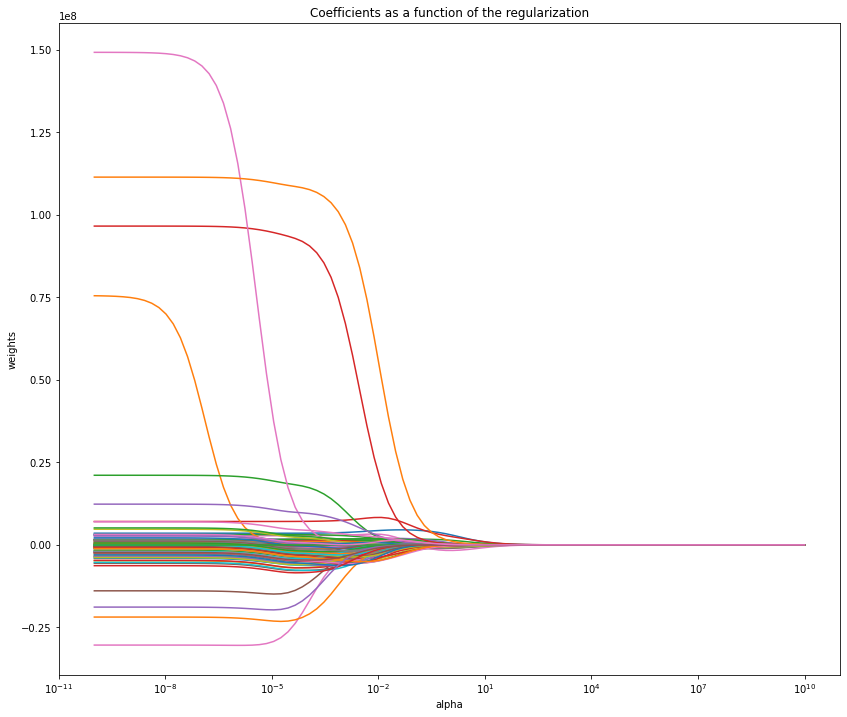

In [59]:
print_coefs(model, X_train, y_train, alphas=alphas)

* The model is merging correctly.

### *d -* Support Vectors Machine

In [60]:
model = LinearSVR()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  C = np.logspace(-5, 0, 5),
  epsilon = [0, 0.01, 0.1, 0.5, 1, 2],
  loss = ["epsilon_insensitive","squared_epsilon_insensitive"],
  max_iter = [10, 100, 1000])

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [61]:
plot_grid(grid, metrics)

In [62]:
plot_metrics(grid, metrics)

In [63]:
ml_log.grid_report(grid, metrics, 'Support Vector Machine')

Best neg mean absolute error: -5829721.040034868
Best r2: 0.40117760373070377


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                            ...                           
Support Vector Machine       0.007108      0.000119  ...      0.07981             1

[1 rows x 11 columns]

In [64]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 5943841.408536446
R²: 0.12530934052548925


### *d -* Random Forest

In [65]:
model = RandomForestRegressor()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  bootstrap=[True, False]
  )

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [66]:
plot_grid(grid,metrics)

In [67]:
plot_metrics(grid, metrics)

In [68]:
ml_log.grid_report(grid, metrics, 'Random Forest')

Best neg mean absolute error: -2026342.8626039382
Best r2: 0.7837507167124275


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                   ...                           
Random Forest       0.862856      0.018728  ...     0.152668             1

[1 rows x 11 columns]

In [69]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 2547269.091823856
R²: 0.7617362301239238


### *e -* XGBoost Regressor

In [70]:
model = XGBRegressor(objective ='reg:squarederror')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  n_estimators=[100, 200, 300],
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  colsample_bytree=[0.25, 0.5, 0.75, 1]
  )

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [71]:
plot_grid(grid, metrics)

In [72]:
plot_metrics(grid, metrics)

In [73]:
ml_log.grid_report(grid, metrics, 'XGBoost Regressor')

Best neg mean absolute error: -1871089.4699600548
Best r2: 0.7956711400914145


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                       ...                           
XGBoost Regressor       0.893621      0.003445  ...      0.11786             1

[1 rows x 11 columns]

In [74]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 2024708.257407606
R²: 0.8803297274850472


## ***Results***

* Let's take a look at our results by algorithm:

In [75]:
ml_log.show_report()

Mean fit time  ...  Rank test r2
Algorithm                                  ...              
Mean Dummy Regressor             0.001802  ...             1
Median Dummy Regressor           0.002222  ...             1
Linear Regression                0.025132  ...             1
Linear Regression (subset)       0.007464  ...             1
Elastic Net                      0.068964  ...             1
Support Vector Machine           0.007108  ...             1
Random Forest                    0.862856  ...             1
XGBoost Regressor                0.893621  ...             1

[8 rows x 11 columns]

The *Random Forest* and the *XGBoost* models seem very close in terms of *mean absolute error* and *R²* scores. However, we select the XGBoost regressor for the following reasons:
* The training and fitting times are lower,
* The standard deviation for both the *mean absolute error* and *R²* scores are lower, which means the model is more stable.

We can apply the *Campus & split* methodology with this performant model, are the remarks in this previous part still relevant ?

In [76]:
split_deviation(model_best, dataframe, pipeline_steps, random_states)

* As we can see, the random state seed still has a major impact on this advanced machine learning model performances.

## *C -* Model Explanation

Our model has been trained, in this part, we are going to explain its predictions.

### *a -* Model Tree

* The XGBoost regressor being a tree based model, we can plot its tree. We could theorically use this tree to make predictions.

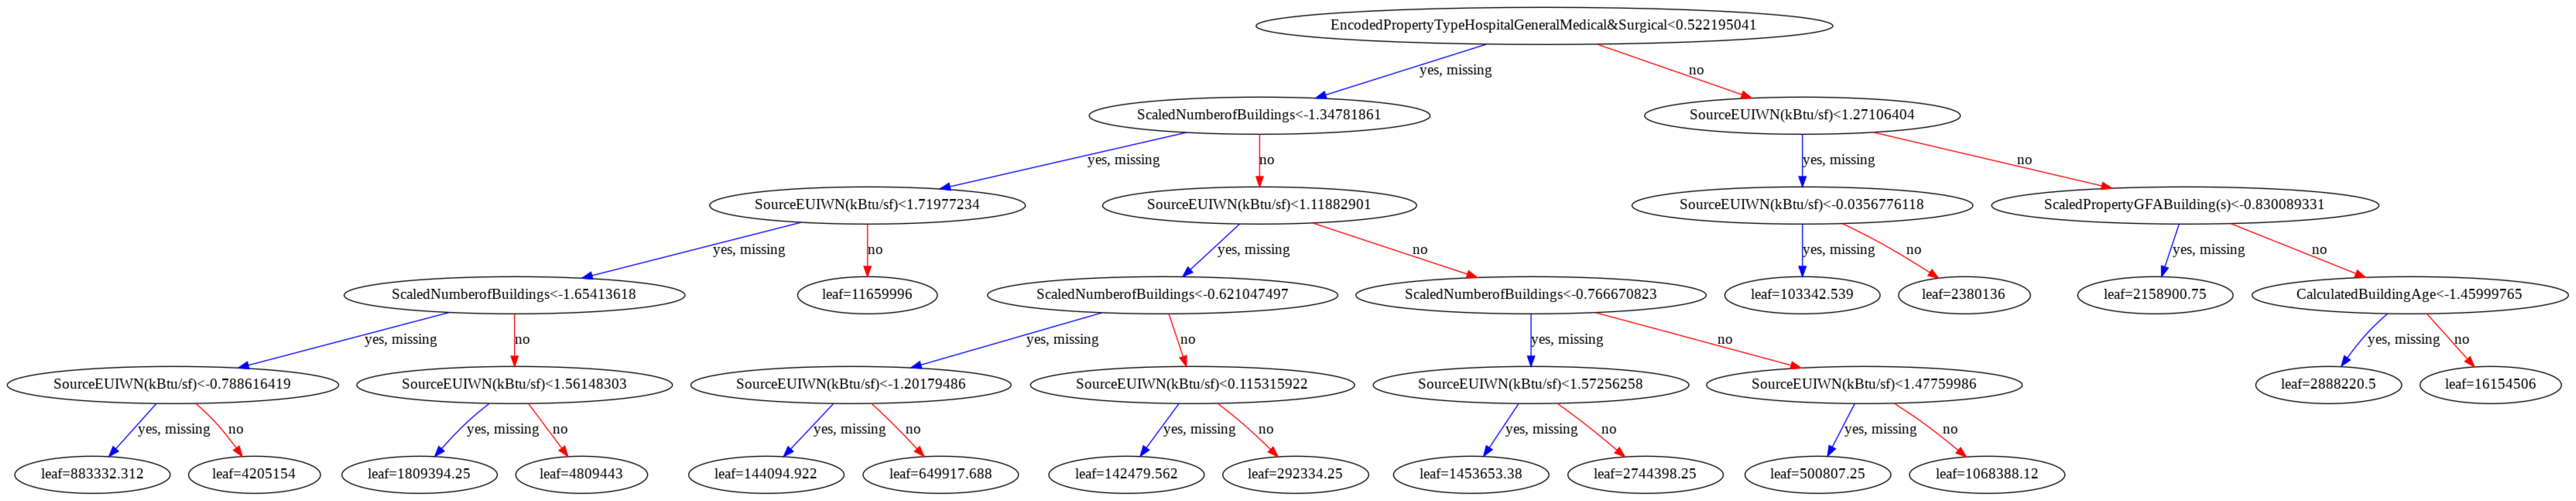

In [77]:
plot_tree(model_best)
fig = plt.gcf()
fig.set_size_inches(100, 75)
fig.savefig('tree.png')

### *b -* Global Feature Importance

* We implement the SHAP method in order to go further with the model explanation:

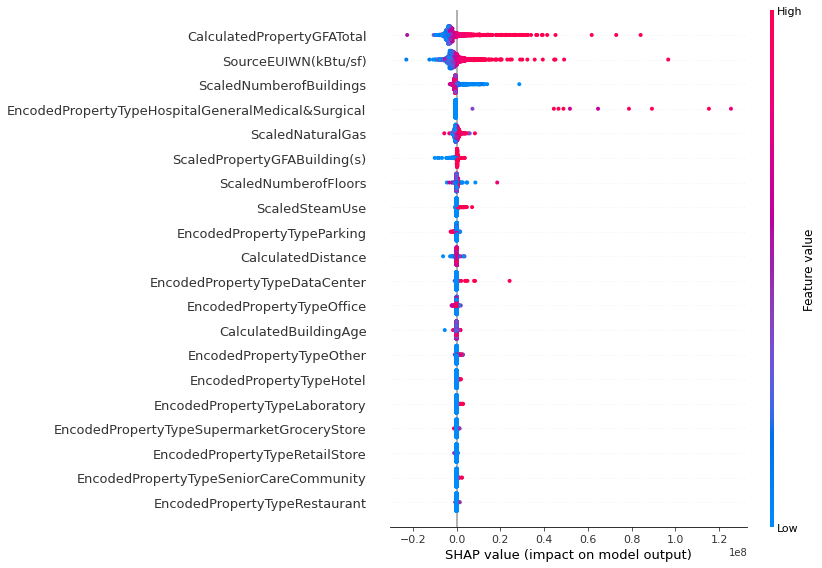

In [78]:
model_explainer = shap.TreeExplainer(model_best)
shap_values = model_explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

* We can look into each feature and see how it reacts compared to the next most correlated feature:

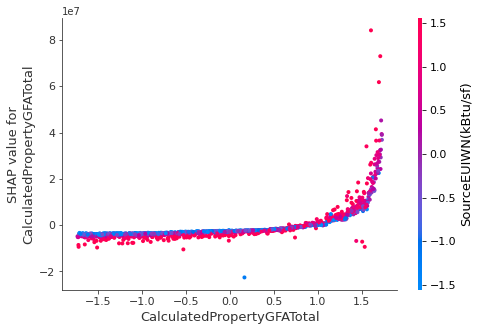

In [79]:
shap.dependence_plot('CalculatedPropertyGFATotal', shap_values, X_train)

### *c -* Local Feature Importance

* We can also explain the predictions for specific samples by plotling the *force plot*:

In [80]:
sample_index = None # Fill in this variable to check the explanation for a specific sample

shap.initjs()
if sample_index is None:
  sample_index = random.choice(range(X_test.shape[0]))
  print(f'Random sample index: {sample_index}')
shap.force_plot(model_explainer.expected_value, shap_values[sample_index], X_test.iloc[[sample_index]])

Random sample index: 315


# ***5 -*** Greenhouse Gas Emissions Prediction

We are going to apply the exact same methodology on the greenhouse gas emissions predictions.

## *A -* Model Selection

In [81]:
target = 'TotalGHGEmissions'

* We reinitialize our datasets, applying the *CampusFilter* step:

In [82]:
pipeline = Pipeline(pipeline_steps)
X_train, X_test, y_train, y_test = train_test(dataframe, targets, target, pipeline, random_state=88)

In [83]:
ml_log = MlLog()

### *a -* DummyRegressor

In [84]:
model = DummyRegressor(strategy = 'mean')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [85]:
ml_log.grid_report(grid, metrics, 'Mean Dummy Regressor')

Best neg mean absolute error: -167.8015364302601
Best r2: -0.02610611924213644


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                          ...                           
Mean Dummy Regressor       0.001503        0.0005  ...     0.026865             1

[1 rows x 11 columns]

In [86]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 204.9490078719787
R²: -0.003431713202326714


In [87]:
model = DummyRegressor(strategy = 'median')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [88]:
ml_log.grid_report(grid, metrics, 'Median Dummy Regressor')

Best neg mean absolute error: -131.57953065683074
Best r2: -0.08998439804497696


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                            ...                           
Median Dummy Regressor       0.001472      0.000558  ...     0.040058             1

[1 rows x 11 columns]

In [89]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 173.73009202453989
R²: -0.03876776750095723


### *b -* Linear Regression

#### *Baseline Model*

In [90]:
model = LinearRegression()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics, 
  fit_intercept=[True,False]
  )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [91]:
plot_grid(grid, metrics)

In [92]:
ml_log.grid_report(grid, metrics, 'Linear Regression')

Best neg mean absolute error: -288834480794.3635
Best r2: -6.639458580783812e+20


Mean fit time  Std fit time  ...   Std test r2  Rank test r2
Algorithm                                       ...                            
Linear Regression       0.012656      0.000133  ...  9.734236e+20             1

[1 rows x 11 columns]

In [93]:
y_pred = model_best.predict(X_test)
performance_report(y_test, y_pred)

Mean Absolute Error: 4234286069801.4453
R²: -6.118181670116169e+21


In [94]:
X_train_reg = X_train.drop(get_feat(X_train, 'Encoded'), axis=1)
X_test_reg = X_test.drop(get_feat(X_test, 'Encoded'), axis=1)
X_train_reg.head()

SourceEUIWN(kBtu/sf)  ...  CalculatedBuildingAge
OSEBuildingID                        ...                       
21689                      0.295603  ...              -0.665730
317                        1.581538  ...              -0.586130
355                        1.415579  ...              -0.347331
21145                      0.637021  ...              -0.783399
395                        0.797384  ...              -0.347331

[5 rows x 9 columns]

In [95]:
model = LinearRegression()
grid, model_best = grid_search(model, X_train_reg, y_train, metrics=metrics,
  fit_intercept=[True,False]
  )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [96]:
plot_grid(grid, metrics)

In [97]:
ml_log.grid_report(grid, metrics, 'Linear Regression (subset)')

Best neg mean absolute error: -156.9024296143088
Best r2: 0.0792622590434505


Mean fit time  ...  Rank test r2
Algorithm                                  ...              
Linear Regression (subset)       0.004787  ...             1

[1 rows x 11 columns]

In [98]:
y_pred = model_best.predict(X_test_reg)
performance_report(y_test, y_pred)

Mean Absolute Error: 188.66092536114712
R²: 0.17693597093645208


### *c -* ElasticNet

In [99]:
alphas = np.logspace(-10, 10, 100)
model = ElasticNet()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics, 
  alpha=alphas)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [100]:
plot_grid(grid,metrics)

In [101]:
plot_metric(grid, metrics, 'alpha', 'log')

In [102]:
ml_log.grid_report(grid, metrics, 'Elastic Net')

Best neg mean absolute error: -130.55670191852127
Best r2: 0.3619571268763707


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                 ...                           
Elastic Net       0.051906      0.025001  ...     0.156183             1

[1 rows x 11 columns]

In [103]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 153.57635816754333
R²: 0.5042340334813827


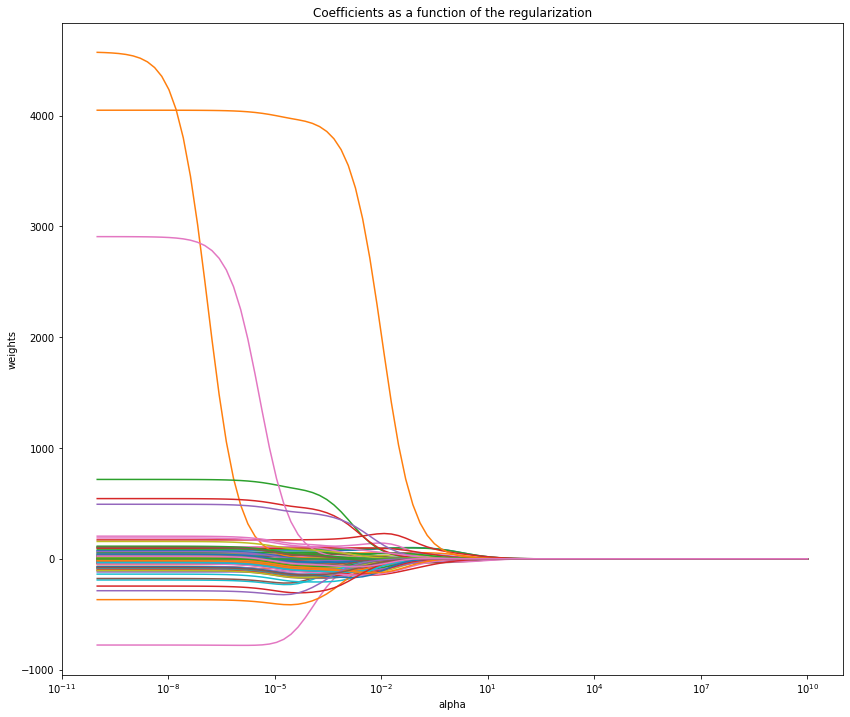

In [104]:
print_coefs(model, X_train, y_train, alphas=alphas)

### *d -* Support Vectors Machine

In [105]:
model = LinearSVR()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  C = np.logspace(-5, 0, 5),
  epsilon = [0, 0.01, 0.1, 0.5, 1, 2],
  loss = ["epsilon_insensitive","squared_epsilon_insensitive"],
  max_iter = [10, 100, 1000])

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [106]:
plot_grid(grid, metrics)

In [107]:
plot_metrics(grid, metrics)

In [108]:
ml_log.grid_report(grid, metrics, 'Support Vector Machine')

Best neg mean absolute error: -125.5646899162642
Best r2: 0.3715127181002328


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                            ...                           
Support Vector Machine       0.016456      0.000227  ...     0.192318             1

[1 rows x 11 columns]

In [109]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 140.6238852561459
R²: 0.05293250502975899


### *d -* Random Forest

In [110]:
model = RandomForestRegressor()
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  bootstrap=[True, False]
  )

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [111]:
plot_grid(grid,metrics)

In [112]:
plot_metrics(grid, metrics)

In [113]:
ml_log.grid_report(grid, metrics, 'Random Forest')

Best neg mean absolute error: -56.60989761761518
Best r2: 0.6777522543672487


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                   ...                           
Random Forest       1.060939      0.011716  ...     0.131664             1

[1 rows x 11 columns]

In [114]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 82.00450653802211
R²: 0.7481566293506734


### *e -* XGBoost Regressor

In [115]:
model = XGBRegressor(objective ='reg:squarederror')
grid, model_best = grid_search(model, X_train, y_train, metrics=metrics,
  n_estimators=[100, 200, 300],
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  colsample_bytree=[0.25, 0.5, 0.75, 1]
  )

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [116]:
plot_grid(grid, metrics)

In [117]:
plot_metrics(grid, metrics)

In [118]:
ml_log.grid_report(grid, metrics, 'XGBoost Regressor')

Best neg mean absolute error: -51.48526981166723
Best r2: 0.7468652353376644


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                       ...                           
XGBoost Regressor       1.110912      0.006605  ...      0.14292             1

[1 rows x 11 columns]

In [119]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 63.98825261665633
R²: 0.872926018673624


## ***Results***

* Let's take a look at our results by algorithm:

In [120]:
ml_log.show_report()

Mean fit time  ...  Rank test r2
Algorithm                                  ...              
Mean Dummy Regressor             0.001503  ...             1
Median Dummy Regressor           0.001472  ...             1
Linear Regression                0.012656  ...             1
Linear Regression (subset)       0.004787  ...             1
Elastic Net                      0.051906  ...             1
Support Vector Machine           0.016456  ...             1
Random Forest                    1.060939  ...             1
XGBoost Regressor                1.110912  ...             1

[8 rows x 11 columns]

In [121]:
split_deviation(model_best, dataframe, pipeline_steps, random_states)

## *C -* Model Explanation

### *a -* Model Tree

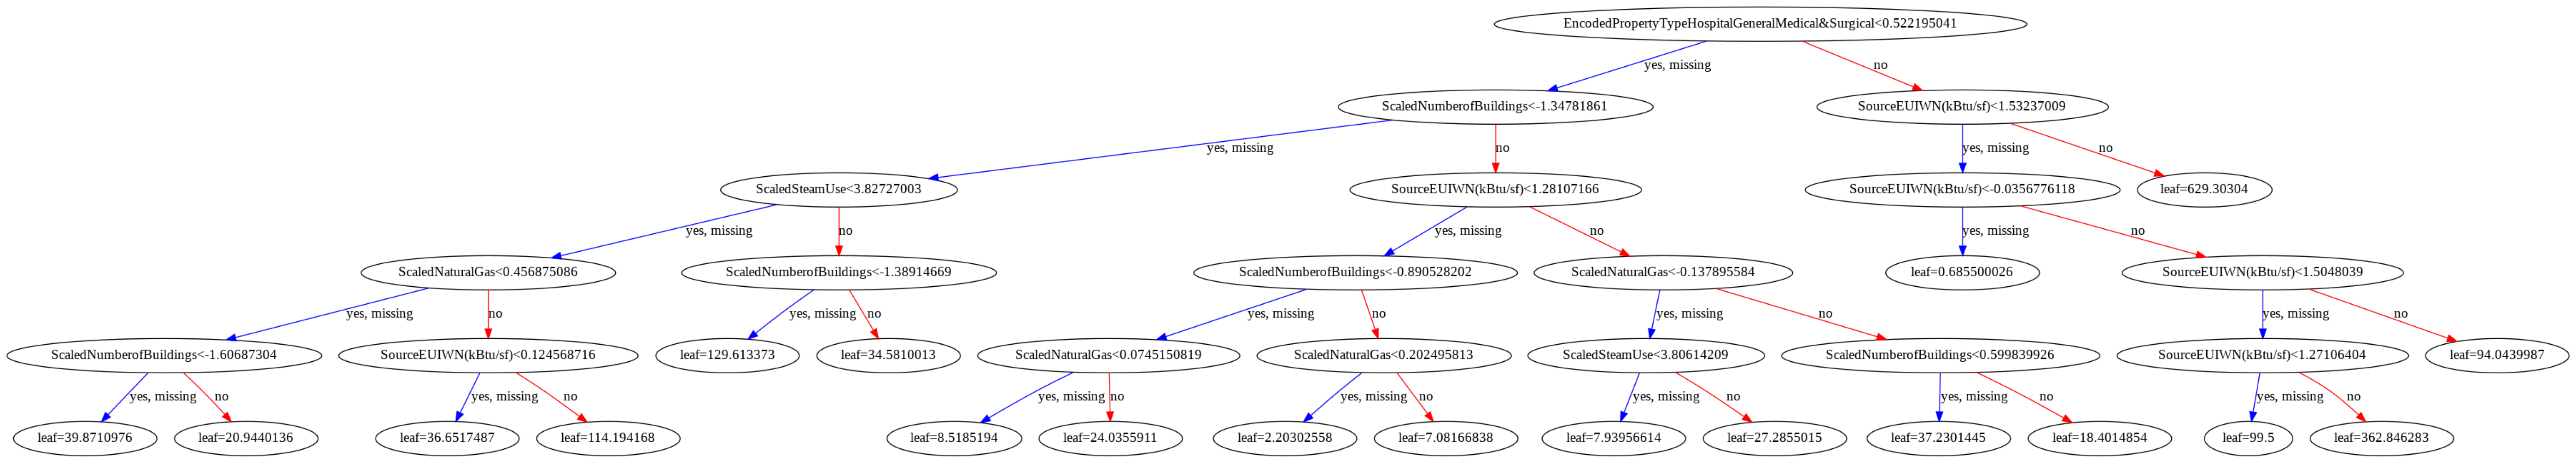

In [122]:
plot_tree(model_best)
fig = plt.gcf()
fig.set_size_inches(100, 75)
fig.savefig('tree.png')

### *b -* Global Feature Importance

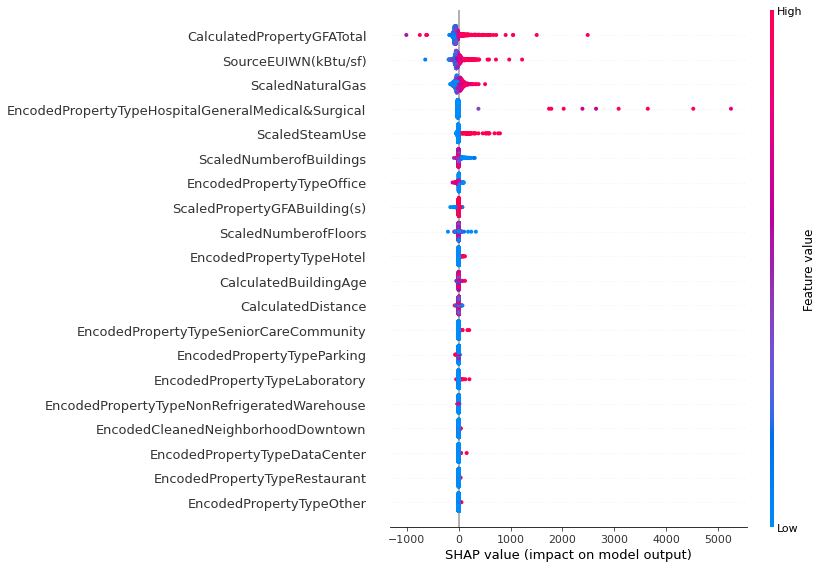

In [123]:
model_explainer = shap.TreeExplainer(model_best)
shap_values = model_explainer.shap_values(X_train, check_additivity=False)
shap.summary_plot(shap_values, X_train)

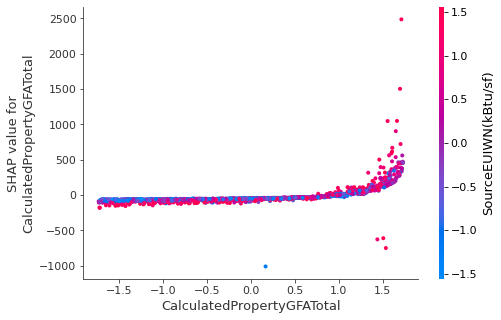

In [124]:
shap.dependence_plot('CalculatedPropertyGFATotal', shap_values, X_train)

### *c -* Local Feature Importance

In [125]:
sample_index = None

shap.initjs()
if sample_index is None:
  sample_index = random.choice(range(X_test.shape[0]))
  print(f'Random sample index: {sample_index}')
shap.force_plot(model_explainer.expected_value, shap_values[sample_index], X_test.iloc[[sample_index]])

Random sample index: 175


## *D -* Energy Star Score

* We will now train a model on the dataset including the *Energy Star Score* feature to evaluate its impact on performances.
* We reproduce the exact same steps of the methodology to obtain viable results.

In [126]:
pipeline_steps_energystar = pipeline_steps.copy()
pipeline_steps_energystar.pop(3) # We remove the EnergyStarFilter, keeping the EnergyStarScore
pipeline = Pipeline(pipeline_steps_energystar)
X_train_energystar, X_test_energystar, y_train, y_test = train_test(dataframe, targets, target, pipeline, random_state=88)
pipeline_steps_energystar

[('FeaturesFilter',
  FunctionTransformer(func=<function FeaturesFilter at 0x7f7fb83124d0>)),
 ('SamplesFilter',
  FunctionTransformer(func=<function SamplesFilters at 0x7f7fb8308b00>)),
 ('CampusFilter',
  FunctionTransformer(func=<function CampusFilter at 0x7f7fb8312560>)),
 ('EnergyTransformer',
  FunctionTransformer(func=<function EnergyTransformer at 0x7f7fb8403200>)),
 ('StructureTransformer',
  FunctionTransformer(func=<function StructureTransformer at 0x7f7fb7fe0b00>)),
 ('DistanceCalculator',
  FunctionTransformer(func=<function DistanceCalculator at 0x7f7fb7fe0e60>)),
 ('AgeCalculator',
  FunctionTransformer(func=<function AgeCalculator at 0x7f7fb8308ef0>)),
 ('NeighborhoodCleaner',
  FunctionTransformer(func=<function NeighborhoodCleaner at 0x7f7fb6fa0050>)),
 ('CatEncoder', CatEncoder(features=['CleanedNeighborhood', 'BuildingType'])),
 ('TypeEncoder',
  TypeEncoder(features=['LargestPropertyUseType', 'SecondLargestPropertyUseType',
                        'ThirdLargestProp

In [127]:
X_train_energystar.head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
21689                      0.345207  ...                                 0.0
355                        1.493459  ...                                 0.0
21145                      0.718416  ...                                 0.0
395                        0.878560  ...                                 0.0
390                       -0.266887  ...                                 0.0

[5 rows x 66 columns]

In [128]:
ml_log = MlLog()

* We drop the *Energy Star Score* from the train and test sets to be able to compare the performances on the same samples:

In [129]:
X_train, X_test = X_train_energystar.drop('ENERGYSTARScore', axis=1), X_test_energystar.drop('ENERGYSTARScore', axis=1)
X_train.head()

SourceEUIWN(kBtu/sf)  ...  EncodedPropertyTypeWorshipFacility
OSEBuildingID                        ...                                    
21689                      0.345207  ...                                 0.0
355                        1.493459  ...                                 0.0
21145                      0.718416  ...                                 0.0
395                        0.878560  ...                                 0.0
390                       -0.266887  ...                                 0.0

[5 rows x 65 columns]

1. We train our model on the train set whitout the *Energy Star Score*:

In [130]:
model = XGBRegressor(objective ='reg:squarederror')
grid, model_best = random_search(model, X_train, y_train, metrics=metrics,
  n_estimators=[100, 200, 300],
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  colsample_bytree=[0.25, 0.5, 0.75, 1]
  )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [131]:
plot_grid(grid, metrics)

In [132]:
plot_metrics(grid, metrics)

In [133]:
ml_log.grid_report(grid, metrics, 'XGBoost Regressor')

Best neg mean absolute error: -59.42336880401272
Best r2: 0.7471888407435001


Mean fit time  Std fit time  ...  Std test r2  Rank test r2
Algorithm                                       ...                           
XGBoost Regressor       0.623358      0.003035  ...      0.14041             1

[1 rows x 11 columns]

In [134]:
y_pred = model_best.predict(X_test)
performance_report(y_test,y_pred)

Mean Absolute Error: 60.89316762212297
R²: 0.8975802855189238


2. We train our model with the *Energy Star Score* feature:

In [135]:
model = XGBRegressor(objective ='reg:squarederror')
grid, model_best = random_search(model, X_train_energystar, y_train, metrics=metrics,
  n_estimators=[100, 200, 300],
  max_depth=[5, 20, 50],
  min_samples_leaf=[1, 2, 5, 10],
  colsample_bytree=[0.25, 0.5, 0.75, 1]
  )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [136]:
plot_grid(grid, metrics)

In [137]:
plot_metrics(grid, metrics)

In [138]:
ml_log.grid_report(grid, metrics, 'StarScore XGBoost Regressor')

Best neg mean absolute error: -58.55747620430302
Best r2: 0.7613832992781001


Mean fit time  ...  Rank test r2
Algorithm                                   ...              
StarScore XGBoost Regressor        0.51448  ...             1

[1 rows x 11 columns]

In [139]:
y_pred = model_best.predict(X_test_energystar)
performance_report(y_test,y_pred)

Mean Absolute Error: 61.36468158596558
R²: 0.8883712935580248


## ***Results***

In [141]:
ml_log.show_report()

Mean fit time  ...  Rank test r2
Algorithm                                   ...              
XGBoost Regressor                 0.623358  ...             1
StarScore XGBoost Regressor       0.514480  ...             1

[2 rows x 11 columns]

* As we can see, the *Energy Star Score* feature adds negligeable performance to our model.
* However, it still improves the deviations of our model thus its stability.

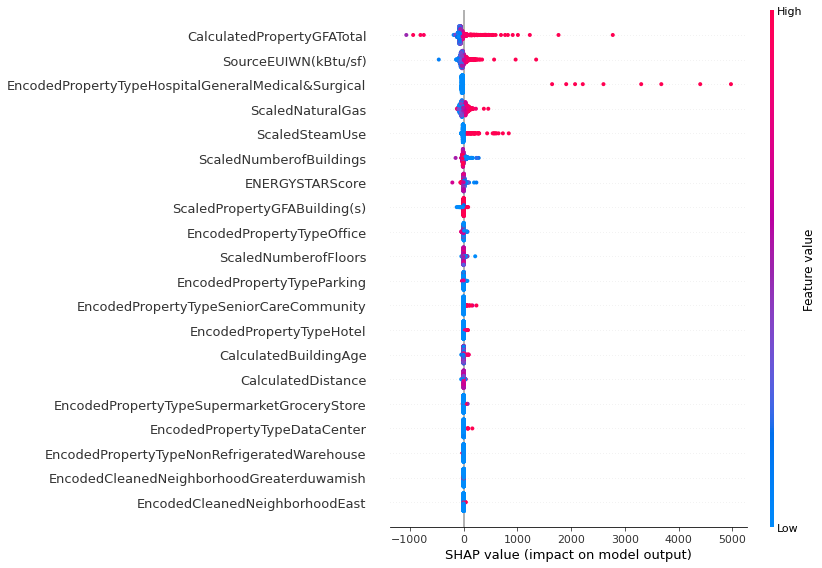

In [142]:
model_explainer = shap.TreeExplainer(model_best)
shap_values = model_explainer.shap_values(X_train_energystar, check_additivity=False)
shap.summary_plot(shap_values, X_train_energystar)

* The *Energy Star Score* has taken the seventh place in the list of the most important features.

# ***+1 -*** **Conclusion**

We have succesfully selected, trained, and optimized a model to predict the energy consumption and greenhouse gas emissions of the Seattle non-residential buildings.

Random state seeds and splits have an important impact on the models performance which highlights the need to obtain more training data for production, but we now have a Proof of Concept.

In order to improve this project, we could:
* Add straficication for the campuses modalities in order to balance the train and test sets.
* Train more advanced models such as *Deep Neural Networks*.

Thanks for reading the project,

*Thibaud*